In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 60))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

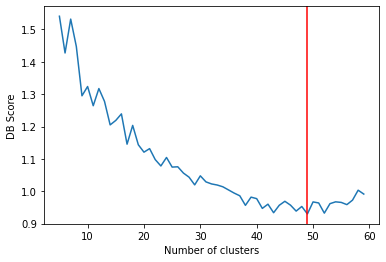

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

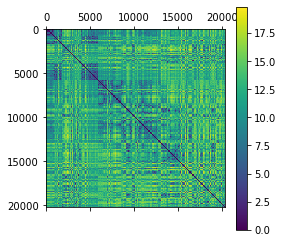

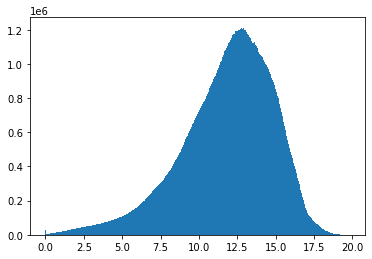

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

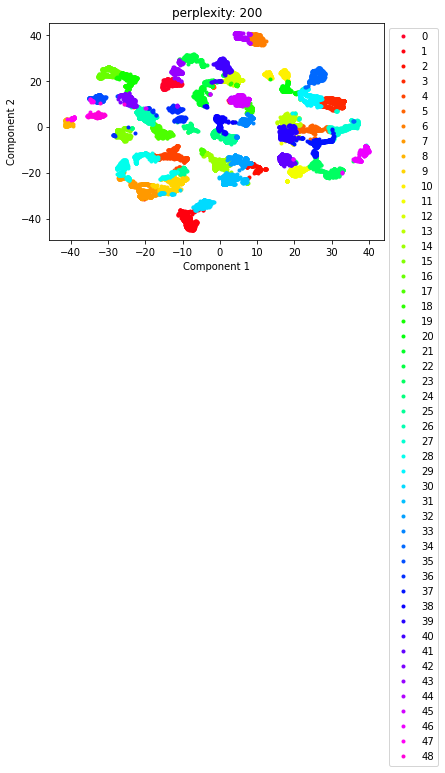

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9892573793919085


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.09225507457551657
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.8344267955801106
layer 6: 0.587189226519337
layer 7: 0.37858252762430944
layer 8: 0.20860669889502764
layer 9: 0.12168724102209946
layer 10: 0.05987784875690608
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.900 | Reg loss: 0.021 | Tree loss: 3.900 | Accuracy: 0.051500 | 7.47 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.896 | Reg loss: 0.020 | Tree loss: 3.896 | Accuracy: 0.029500 | 6.721 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.893 | Reg loss: 0.020 | Tree loss: 3.893 | Accuracy: 0.034000 | 6.552 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.889 | Reg loss: 0.019 | Tree loss: 3.889 | Accuracy: 0.065500 | 6.417 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.888 | Reg loss: 0.019 | Tree loss: 3.888 | Accuracy: 0.053000 | 6.376 sec/iter
Epoch: 00 | Batch: 005 / 011 | Tot

Epoch: 04 | Batch: 009 / 011 | Total loss: 3.825 | Reg loss: 0.015 | Tree loss: 3.825 | Accuracy: 0.076500 | 6.248 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 3.814 | Reg loss: 0.015 | Tree loss: 3.814 | Accuracy: 0.064846 | 6.207 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 3.895 | Reg loss: 0.014 | Tree loss: 3.895 | Accuracy: 0.069000 | 6.202 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.888 | Reg loss: 0.014 | Tree loss: 3.888 | Accuracy: 0.100500 | 6.184 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.882 | Reg loss: 0.014 | Tree loss: 3.882 | Accuracy: 0.112500 | 6.167 sec/iter
Epoch: 05 | Batch: 003 / 011 | T

Epoch: 09 | Batch: 007 / 011 | Total loss: 3.691 | Reg loss: 0.015 | Tree loss: 3.691 | Accuracy: 0.094000 | 5.815 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 3.671 | Reg loss: 0.016 | Tree loss: 3.671 | Accuracy: 0.089000 | 5.811 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 3.667 | Reg loss: 0.016 | Tree loss: 3.667 | Accuracy: 0.083000 | 5.806 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 3.649 | Reg loss: 0.016 | Tree loss: 3.649 | Accuracy: 0.098976 | 5.788 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 3.857 | Reg loss: 0.015 | Tree loss: 3.857 | Accuracy: 0.118000 | 5.79 sec/iter
Epoch: 10 | Batch: 001 / 011 | To

Epoch: 14 | Batch: 005 / 011 | Total loss: 3.521 | Reg loss: 0.017 | Tree loss: 3.521 | Accuracy: 0.102000 | 5.695 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 3.488 | Reg loss: 0.018 | Tree loss: 3.488 | Accuracy: 0.108000 | 5.693 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 3.492 | Reg loss: 0.018 | Tree loss: 3.492 | Accuracy: 0.116500 | 5.692 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 3.461 | Reg loss: 0.018 | Tree loss: 3.461 | Accuracy: 0.130000 | 5.691 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 3.449 | Reg loss: 0.018 | Tree loss: 3.449 | Accuracy: 0.117000 | 5.689 sec/iter
Epoch: 14 | Batch: 010 / 011 | Total loss: 3.449 | Reg loss: 0.019 | Tree loss: 3.449 | Accuracy: 0.081911 | 5.677 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906

Epoch: 19 | Batch: 003 / 011 | Total loss: 3.424 | Reg loss: 0.020 | Tree loss: 3.424 | Accuracy: 0.101500 | 5.604 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 3.366 | Reg loss: 0.020 | Tree loss: 3.366 | Accuracy: 0.110500 | 5.603 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 3.334 | Reg loss: 0.020 | Tree loss: 3.334 | Accuracy: 0.101000 | 5.602 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 3.316 | Reg loss: 0.021 | Tree loss: 3.316 | Accuracy: 0.113500 | 5.601 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 3.294 | Reg loss: 0.021 | Tree loss: 3.294 | Accuracy: 0.131000 | 5.6 sec/iter
Epoch: 19 | Batch: 008 / 011 | Total loss: 3.274 | Reg loss: 0.021 | Tree loss: 3.274 | Accuracy: 0.134500 | 5.6 sec/iter
Epoch: 19 | Batch: 009 / 011 | Total loss: 3.254 | Reg loss: 0.021 | Tree loss: 3.254 | Accuracy: 0.129000 | 5.599 sec/iter
Epoch: 19 | Batch: 010 / 011 | Total loss: 3.204 | Reg loss: 0.021 | Tree loss: 3.204 | Accuracy: 0.112628 | 5.592 sec/iter
Average spar

Epoch: 24 | Batch: 001 / 011 | Total loss: 3.353 | Reg loss: 0.022 | Tree loss: 3.353 | Accuracy: 0.107000 | 5.544 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 3.314 | Reg loss: 0.022 | Tree loss: 3.314 | Accuracy: 0.119000 | 5.543 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 3.269 | Reg loss: 0.022 | Tree loss: 3.269 | Accuracy: 0.115500 | 5.543 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 3.236 | Reg loss: 0.022 | Tree loss: 3.236 | Accuracy: 0.108000 | 5.543 sec/iter
Epoch: 24 | Batch: 005 / 011 | Total loss: 3.168 | Reg loss: 0.022 | Tree loss: 3.168 | Accuracy: 0.124000 | 5.543 sec/iter
Epoch: 24 | Batch: 006 / 011 | Total loss: 3.168 | Reg loss: 0.023 | Tree loss: 3.168 | Accuracy: 0.142500 | 5.543 sec/iter
Epoch: 24 | Batch: 007 / 011 | Total loss: 3.144 | Reg loss: 0.023 | Tree loss: 3.144 | Accuracy: 0.145000 | 5.542 sec/iter
Epoch: 24 | Batch: 008 / 011 | Total loss: 3.130 | Reg loss: 0.023 | Tree loss: 3.130 | Accuracy: 0.137500 | 5.542 sec/iter
Epoch: 2

Epoch: 29 | Batch: 000 / 011 | Total loss: 3.276 | Reg loss: 0.024 | Tree loss: 3.276 | Accuracy: 0.113500 | 5.507 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 3.214 | Reg loss: 0.024 | Tree loss: 3.214 | Accuracy: 0.121500 | 5.506 sec/iter
Epoch: 29 | Batch: 002 / 011 | Total loss: 3.200 | Reg loss: 0.024 | Tree loss: 3.200 | Accuracy: 0.126000 | 5.505 sec/iter
Epoch: 29 | Batch: 003 / 011 | Total loss: 3.157 | Reg loss: 0.024 | Tree loss: 3.157 | Accuracy: 0.126000 | 5.504 sec/iter
Epoch: 29 | Batch: 004 / 011 | Total loss: 3.118 | Reg loss: 0.024 | Tree loss: 3.118 | Accuracy: 0.110000 | 5.504 sec/iter
Epoch: 29 | Batch: 005 / 011 | Total loss: 3.094 | Reg loss: 0.024 | Tree loss: 3.094 | Accuracy: 0.134000 | 5.503 sec/iter
Epoch: 29 | Batch: 006 / 011 | Total loss: 3.048 | Reg loss: 0.024 | Tree loss: 3.048 | Accuracy: 0.128000 | 5.503 sec/iter
Epoch: 29 | Batch: 007 / 011 | Total loss: 3.048 | Reg loss: 0.024 | Tree loss: 3.048 | Accuracy: 0.156000 | 5.503 sec/iter
Epoch: 2

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 34 | Batch: 000 / 011 | Total loss: 3.197 | Reg loss: 0.025 | Tree loss: 3.197 | Accuracy: 0.119500 | 5.478 sec/iter
Epoch: 34 | Batch: 001 / 011 | Total loss: 3.171 | Reg loss: 0.025 | Tree loss: 3.171 | Accuracy: 0.138500 | 5.477 sec/iter
Epoch: 34 | Batch: 002 / 011 | Total loss: 3.128 | Reg loss: 0.025 | Tree loss: 3.128 | Accuracy: 0.135500 | 5.477 sec/iter
Epoch: 34 | Batch: 003 / 011 | Total loss: 3.075 | Reg loss: 0.025 | Tree loss: 3.075 | Accuracy: 0.157000 | 5.476 sec/iter
Epoch: 34 | Batch: 004 / 011 | Total loss: 3.038 | Reg loss: 0.025 | Tree loss: 3.038 | Accuracy: 0.135000 | 5.476 sec/iter
Epoch: 34 | Batch: 005 / 011 | T

Epoch: 38 | Batch: 009 / 011 | Total loss: 2.886 | Reg loss: 0.026 | Tree loss: 2.886 | Accuracy: 0.173000 | 5.46 sec/iter
Epoch: 38 | Batch: 010 / 011 | Total loss: 2.946 | Reg loss: 0.026 | Tree loss: 2.946 | Accuracy: 0.167235 | 5.456 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 39 | Batch: 000 / 011 | Total loss: 3.195 | Reg loss: 0.026 | Tree loss: 3.195 | Accuracy: 0.153000 | 5.457 sec/iter
Epoch: 39 | Batch: 001 / 011 | Total loss: 3.123 | Reg loss: 0.026 | Tree loss: 3.123 | Accuracy: 0.160500 | 5.456 sec/iter
Epoch: 39 | Batch: 002 / 011 | Total loss: 3.064 | Reg loss: 0.026 | Tree loss: 3.064 | Accuracy: 0.165500 | 5.456 sec/iter
Epoch: 39 | Batch: 003 / 011 | To

Epoch: 43 | Batch: 007 / 011 | Total loss: 2.845 | Reg loss: 0.027 | Tree loss: 2.845 | Accuracy: 0.166500 | 5.588 sec/iter
Epoch: 43 | Batch: 008 / 011 | Total loss: 2.829 | Reg loss: 0.027 | Tree loss: 2.829 | Accuracy: 0.176000 | 5.589 sec/iter
Epoch: 43 | Batch: 009 / 011 | Total loss: 2.843 | Reg loss: 0.027 | Tree loss: 2.843 | Accuracy: 0.148500 | 5.592 sec/iter
Epoch: 43 | Batch: 010 / 011 | Total loss: 2.817 | Reg loss: 0.027 | Tree loss: 2.817 | Accuracy: 0.177474 | 5.589 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 44 | Batch: 000 / 011 | Total loss: 3.120 | Reg loss: 0.027 | Tree loss: 3.120 | Accuracy: 0.190500 | 5.6 sec/iter
Epoch: 44 | Batch: 001 / 011 | Tot

Epoch: 48 | Batch: 005 / 011 | Total loss: 2.850 | Reg loss: 0.027 | Tree loss: 2.850 | Accuracy: 0.214000 | 5.719 sec/iter
Epoch: 48 | Batch: 006 / 011 | Total loss: 2.824 | Reg loss: 0.027 | Tree loss: 2.824 | Accuracy: 0.221000 | 5.72 sec/iter
Epoch: 48 | Batch: 007 / 011 | Total loss: 2.765 | Reg loss: 0.028 | Tree loss: 2.765 | Accuracy: 0.206500 | 5.723 sec/iter
Epoch: 48 | Batch: 008 / 011 | Total loss: 2.776 | Reg loss: 0.028 | Tree loss: 2.776 | Accuracy: 0.199000 | 5.724 sec/iter
Epoch: 48 | Batch: 009 / 011 | Total loss: 2.759 | Reg loss: 0.028 | Tree loss: 2.759 | Accuracy: 0.185000 | 5.727 sec/iter
Epoch: 48 | Batch: 010 / 011 | Total loss: 2.732 | Reg loss: 0.028 | Tree loss: 2.732 | Accuracy: 0.156997 | 5.723 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237569060

Epoch: 53 | Batch: 003 / 011 | Total loss: 2.886 | Reg loss: 0.028 | Tree loss: 2.886 | Accuracy: 0.260500 | 5.826 sec/iter
Epoch: 53 | Batch: 004 / 011 | Total loss: 2.836 | Reg loss: 0.028 | Tree loss: 2.836 | Accuracy: 0.263500 | 5.826 sec/iter
Epoch: 53 | Batch: 005 / 011 | Total loss: 2.793 | Reg loss: 0.028 | Tree loss: 2.793 | Accuracy: 0.243500 | 5.828 sec/iter
Epoch: 53 | Batch: 006 / 011 | Total loss: 2.772 | Reg loss: 0.028 | Tree loss: 2.772 | Accuracy: 0.230000 | 5.829 sec/iter
Epoch: 53 | Batch: 007 / 011 | Total loss: 2.747 | Reg loss: 0.028 | Tree loss: 2.747 | Accuracy: 0.211500 | 5.832 sec/iter
Epoch: 53 | Batch: 008 / 011 | Total loss: 2.722 | Reg loss: 0.028 | Tree loss: 2.722 | Accuracy: 0.203000 | 5.832 sec/iter
Epoch: 53 | Batch: 009 / 011 | Total loss: 2.710 | Reg loss: 0.028 | Tree loss: 2.710 | Accuracy: 0.201500 | 5.835 sec/iter
Epoch: 53 | Batch: 010 / 011 | Total loss: 2.679 | Reg loss: 0.029 | Tree loss: 2.679 | Accuracy: 0.191126 | 5.831 sec/iter
Average 

Epoch: 58 | Batch: 001 / 011 | Total loss: 2.955 | Reg loss: 0.029 | Tree loss: 2.955 | Accuracy: 0.216500 | 5.915 sec/iter
Epoch: 58 | Batch: 002 / 011 | Total loss: 2.901 | Reg loss: 0.029 | Tree loss: 2.901 | Accuracy: 0.209000 | 5.915 sec/iter
Epoch: 58 | Batch: 003 / 011 | Total loss: 2.869 | Reg loss: 0.029 | Tree loss: 2.869 | Accuracy: 0.235500 | 5.917 sec/iter
Epoch: 58 | Batch: 004 / 011 | Total loss: 2.826 | Reg loss: 0.029 | Tree loss: 2.826 | Accuracy: 0.270000 | 5.918 sec/iter
Epoch: 58 | Batch: 005 / 011 | Total loss: 2.759 | Reg loss: 0.029 | Tree loss: 2.759 | Accuracy: 0.267000 | 5.92 sec/iter
Epoch: 58 | Batch: 006 / 011 | Total loss: 2.754 | Reg loss: 0.029 | Tree loss: 2.754 | Accuracy: 0.224000 | 5.92 sec/iter
Epoch: 58 | Batch: 007 / 011 | Total loss: 2.711 | Reg loss: 0.029 | Tree loss: 2.711 | Accuracy: 0.259500 | 5.923 sec/iter
Epoch: 58 | Batch: 008 / 011 | Total loss: 2.661 | Reg loss: 0.029 | Tree loss: 2.661 | Accuracy: 0.230000 | 5.923 sec/iter
Epoch: 58 

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 63 | Batch: 000 / 011 | Total loss: 2.976 | Reg loss: 0.030 | Tree loss: 2.976 | Accuracy: 0.199500 | 5.989 sec/iter
Epoch: 63 | Batch: 001 / 011 | Total loss: 2.923 | Reg loss: 0.030 | Tree loss: 2.923 | Accuracy: 0.193500 | 5.991 sec/iter
Epoch: 63 | Batch: 002 / 011 | Total loss: 2.885 | Reg loss: 0.030 | Tree loss: 2.885 | Accuracy: 0.192000 | 5.991 sec/iter
Epoch: 63 | Batch: 003 / 011 | Total loss: 2.813 | Reg loss: 0.030 | Tree loss: 2.813 | Accuracy: 0.246500 | 5.993 sec/iter
Epoch: 63 | Batch: 004 / 011 | Total loss: 2.774 | Reg loss: 0.030 | Tree loss: 2.774 | Accuracy: 0.255500 | 5.993 sec/iter
Epoch: 63 | Batch: 005 / 011 | Total loss: 2.746 | Reg loss: 0.030 | Tree loss: 2.746 | Accuracy: 0.268500 | 5.995 sec/iter
Epoch: 63 | Batch: 006 / 011 | Total loss: 2.720 | Reg loss: 0.030 | Tree loss: 2.720 | Accuracy: 0.248500 | 5.996 sec/iter
Epoch: 63 | Batch: 007 / 011 | Total loss: 2.68

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 68 | Batch: 000 / 011 | Total loss: 2.959 | Reg loss: 0.030 | Tree loss: 2.959 | Accuracy: 0.200000 | 6.056 sec/iter
Epoch: 68 | Batch: 001 / 011 | Total loss: 2.899 | Reg loss: 0.030 | Tree loss: 2.899 | Accuracy: 0.213500 | 6.057 sec/iter
Epoch: 68 | Batch: 002 / 011 | Total loss: 2.872 | Reg loss: 0.030 | Tree loss: 2.872 | Accuracy: 0.221500 | 6.058 sec/iter
Epoch: 68 | Batch: 003 / 011 | Total loss: 2.796 | Reg loss: 0.030 | Tree loss: 2.796 | Accuracy: 0.233000 | 6.06 sec/iter
Epoch: 68 | Batch: 004 / 011 | Total loss: 2.765 | Reg loss: 0.030 | Tree loss: 2.765 | Accuracy: 0.273000 | 6.06 sec/iter
Epoch: 68 | Batch: 005 / 011 | Tot

Epoch: 72 | Batch: 009 / 011 | Total loss: 2.587 | Reg loss: 0.031 | Tree loss: 2.587 | Accuracy: 0.225000 | 6.113 sec/iter
Epoch: 72 | Batch: 010 / 011 | Total loss: 2.628 | Reg loss: 0.031 | Tree loss: 2.628 | Accuracy: 0.194539 | 6.11 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 73 | Batch: 000 / 011 | Total loss: 2.929 | Reg loss: 0.031 | Tree loss: 2.929 | Accuracy: 0.202000 | 6.116 sec/iter
Epoch: 73 | Batch: 001 / 011 | Total loss: 2.879 | Reg loss: 0.031 | Tree loss: 2.879 | Accuracy: 0.210000 | 6.117 sec/iter
Epoch: 73 | Batch: 002 / 011 | Total loss: 2.828 | Reg loss: 0.031 | Tree loss: 2.828 | Accuracy: 0.215500 | 6.118 sec/iter
Epoch: 73 | Batch: 003 / 011 | To

Epoch: 77 | Batch: 007 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.225500 | 6.178 sec/iter
Epoch: 77 | Batch: 008 / 011 | Total loss: 2.602 | Reg loss: 0.032 | Tree loss: 2.602 | Accuracy: 0.238000 | 6.179 sec/iter
Epoch: 77 | Batch: 009 / 011 | Total loss: 2.587 | Reg loss: 0.032 | Tree loss: 2.587 | Accuracy: 0.235500 | 6.179 sec/iter
Epoch: 77 | Batch: 010 / 011 | Total loss: 2.620 | Reg loss: 0.032 | Tree loss: 2.620 | Accuracy: 0.266212 | 6.177 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 78 | Batch: 000 / 011 | Total loss: 2.914 | Reg loss: 0.031 | Tree loss: 2.914 | Accuracy: 0.206500 | 6.181 sec/iter
Epoch: 78 | Batch: 001 / 011 | T

Epoch: 82 | Batch: 005 / 011 | Total loss: 2.667 | Reg loss: 0.032 | Tree loss: 2.667 | Accuracy: 0.232000 | 6.209 sec/iter
Epoch: 82 | Batch: 006 / 011 | Total loss: 2.636 | Reg loss: 0.032 | Tree loss: 2.636 | Accuracy: 0.249500 | 6.209 sec/iter
Epoch: 82 | Batch: 007 / 011 | Total loss: 2.633 | Reg loss: 0.032 | Tree loss: 2.633 | Accuracy: 0.215500 | 6.209 sec/iter
Epoch: 82 | Batch: 008 / 011 | Total loss: 2.593 | Reg loss: 0.032 | Tree loss: 2.593 | Accuracy: 0.213500 | 6.21 sec/iter
Epoch: 82 | Batch: 009 / 011 | Total loss: 2.586 | Reg loss: 0.032 | Tree loss: 2.586 | Accuracy: 0.222500 | 6.211 sec/iter
Epoch: 82 | Batch: 010 / 011 | Total loss: 2.590 | Reg loss: 0.032 | Tree loss: 2.590 | Accuracy: 0.238908 | 6.208 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237569060

Epoch: 87 | Batch: 003 / 011 | Total loss: 2.728 | Reg loss: 0.032 | Tree loss: 2.728 | Accuracy: 0.257500 | 6.235 sec/iter
Epoch: 87 | Batch: 004 / 011 | Total loss: 2.703 | Reg loss: 0.032 | Tree loss: 2.703 | Accuracy: 0.263500 | 6.235 sec/iter
Epoch: 87 | Batch: 005 / 011 | Total loss: 2.671 | Reg loss: 0.032 | Tree loss: 2.671 | Accuracy: 0.264500 | 6.236 sec/iter
Epoch: 87 | Batch: 006 / 011 | Total loss: 2.637 | Reg loss: 0.032 | Tree loss: 2.637 | Accuracy: 0.253500 | 6.237 sec/iter
Epoch: 87 | Batch: 007 / 011 | Total loss: 2.615 | Reg loss: 0.033 | Tree loss: 2.615 | Accuracy: 0.236500 | 6.238 sec/iter
Epoch: 87 | Batch: 008 / 011 | Total loss: 2.577 | Reg loss: 0.033 | Tree loss: 2.577 | Accuracy: 0.244000 | 6.239 sec/iter
Epoch: 87 | Batch: 009 / 011 | Total loss: 2.562 | Reg loss: 0.033 | Tree loss: 2.562 | Accuracy: 0.231000 | 6.24 sec/iter
Epoch: 87 | Batch: 010 / 011 | Total loss: 2.542 | Reg loss: 0.033 | Tree loss: 2.542 | Accuracy: 0.252560 | 6.238 sec/iter
Average s

Epoch: 92 | Batch: 001 / 011 | Total loss: 2.835 | Reg loss: 0.033 | Tree loss: 2.835 | Accuracy: 0.276000 | 6.298 sec/iter
Epoch: 92 | Batch: 002 / 011 | Total loss: 2.789 | Reg loss: 0.033 | Tree loss: 2.789 | Accuracy: 0.253000 | 6.298 sec/iter
Epoch: 92 | Batch: 003 / 011 | Total loss: 2.729 | Reg loss: 0.033 | Tree loss: 2.729 | Accuracy: 0.256500 | 6.299 sec/iter
Epoch: 92 | Batch: 004 / 011 | Total loss: 2.668 | Reg loss: 0.033 | Tree loss: 2.668 | Accuracy: 0.260500 | 6.3 sec/iter
Epoch: 92 | Batch: 005 / 011 | Total loss: 2.629 | Reg loss: 0.033 | Tree loss: 2.629 | Accuracy: 0.249000 | 6.3 sec/iter
Epoch: 92 | Batch: 006 / 011 | Total loss: 2.624 | Reg loss: 0.033 | Tree loss: 2.624 | Accuracy: 0.241000 | 6.301 sec/iter
Epoch: 92 | Batch: 007 / 011 | Total loss: 2.592 | Reg loss: 0.033 | Tree loss: 2.592 | Accuracy: 0.241000 | 6.302 sec/iter
Epoch: 92 | Batch: 008 / 011 | Total loss: 2.583 | Reg loss: 0.033 | Tree loss: 2.583 | Accuracy: 0.264000 | 6.303 sec/iter
Epoch: 92 | 

layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 97 | Batch: 000 / 011 | Total loss: 2.858 | Reg loss: 0.033 | Tree loss: 2.858 | Accuracy: 0.249000 | 6.334 sec/iter
Epoch: 97 | Batch: 001 / 011 | Total loss: 2.827 | Reg loss: 0.033 | Tree loss: 2.827 | Accuracy: 0.260000 | 6.334 sec/iter
Epoch: 97 | Batch: 002 / 011 | Total loss: 2.743 | Reg loss: 0.033 | Tree loss: 2.743 | Accuracy: 0.294000 | 6.335 sec/iter
Epoch: 97 | Batch: 003 / 011 | Total loss: 2.721 | Reg loss: 0.033 | Tree loss: 2.721 | Accuracy: 0.261500 | 6.336 sec/iter
Epoch: 97 | Batch: 004 / 011 | Total loss: 2.681 | Reg loss: 0.033 | Tree loss: 2.681 | Accuracy: 0.259000 | 6.336 sec/iter
Epoch: 97 | Batch: 005 / 011 | Total loss: 2.633 | Reg loss: 0.033 | Tree loss: 2.633 | Accuracy: 0.249500 | 6.336 sec/iter
Epoch: 97 | Batch: 006 / 011 | Total loss: 2.600 | Reg loss: 0.033 | Tree loss: 2.600 | Accuracy: 0.241000 | 6.337 sec/iter
Epoch: 97 | Batch: 007 / 011 | Total loss: 2.585 | Reg loss: 0.033 | Tree l

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 102 | Batch: 000 / 011 | Total loss: 2.825 | Reg loss: 0.034 | Tree loss: 2.825 | Accuracy: 0.243500 | 6.363 sec/iter
Epoch: 102 | Batch: 001 / 011 | Total loss: 2.801 | Reg loss: 0.034 | Tree loss: 2.801 | Accuracy: 0.254500 | 6.363 sec/iter
Epoch: 102 | Batch: 002 / 011 | Total loss: 2.719 | Reg loss: 0.034 | Tree loss: 2.719 | Accuracy: 0.289000 | 6.363 sec/iter
Epoch: 102 | Batch: 003 / 011 | Total loss: 2.710 | Reg loss: 0.034 | Tree loss: 2.710 | Accuracy: 0.282500 | 6.364 sec/iter
Epoch: 102 | Batch: 004 / 011 | Total loss: 2.684 | Reg loss: 0.034 | Tree loss: 2.684 | Accuracy: 0.249500 | 6.364 sec/iter
Epoch: 102 | Batch: 005 / 0

Epoch: 106 | Batch: 008 / 011 | Total loss: 2.534 | Reg loss: 0.034 | Tree loss: 2.534 | Accuracy: 0.259000 | 6.388 sec/iter
Epoch: 106 | Batch: 009 / 011 | Total loss: 2.526 | Reg loss: 0.034 | Tree loss: 2.526 | Accuracy: 0.245000 | 6.388 sec/iter
Epoch: 106 | Batch: 010 / 011 | Total loss: 2.521 | Reg loss: 0.034 | Tree loss: 2.521 | Accuracy: 0.252560 | 6.386 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 107 | Batch: 000 / 011 | Total loss: 2.782 | Reg loss: 0.034 | Tree loss: 2.782 | Accuracy: 0.246500 | 6.388 sec/iter
Epoch: 107 | Batch: 001 / 011 | Total loss: 2.760 | Reg loss: 0.034 | Tree loss: 2.760 | Accuracy: 0.253000 | 6.388 sec/iter
Epoch: 107 | Batch: 002 / 0

Epoch: 111 | Batch: 005 / 011 | Total loss: 2.582 | Reg loss: 0.035 | Tree loss: 2.582 | Accuracy: 0.272000 | 6.402 sec/iter
Epoch: 111 | Batch: 006 / 011 | Total loss: 2.566 | Reg loss: 0.035 | Tree loss: 2.566 | Accuracy: 0.262000 | 6.402 sec/iter
Epoch: 111 | Batch: 007 / 011 | Total loss: 2.530 | Reg loss: 0.035 | Tree loss: 2.530 | Accuracy: 0.279500 | 6.402 sec/iter
Epoch: 111 | Batch: 008 / 011 | Total loss: 2.523 | Reg loss: 0.035 | Tree loss: 2.523 | Accuracy: 0.270500 | 6.402 sec/iter
Epoch: 111 | Batch: 009 / 011 | Total loss: 2.485 | Reg loss: 0.035 | Tree loss: 2.485 | Accuracy: 0.250000 | 6.403 sec/iter
Epoch: 111 | Batch: 010 / 011 | Total loss: 2.531 | Reg loss: 0.035 | Tree loss: 2.531 | Accuracy: 0.187713 | 6.401 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 116 | Batch: 002 / 011 | Total loss: 2.679 | Reg loss: 0.035 | Tree loss: 2.679 | Accuracy: 0.265000 | 6.42 sec/iter
Epoch: 116 | Batch: 003 / 011 | Total loss: 2.621 | Reg loss: 0.035 | Tree loss: 2.621 | Accuracy: 0.287000 | 6.421 sec/iter
Epoch: 116 | Batch: 004 / 011 | Total loss: 2.576 | Reg loss: 0.035 | Tree loss: 2.576 | Accuracy: 0.290500 | 6.42 sec/iter
Epoch: 116 | Batch: 005 / 011 | Total loss: 2.548 | Reg loss: 0.035 | Tree loss: 2.548 | Accuracy: 0.250500 | 6.421 sec/iter
Epoch: 116 | Batch: 006 / 011 | Total loss: 2.522 | Reg loss: 0.035 | Tree loss: 2.522 | Accuracy: 0.257500 | 6.421 sec/iter
Epoch: 116 | Batch: 007 / 011 | Total loss: 2.488 | Reg loss: 0.035 | Tree loss: 2.488 | Accuracy: 0.284500 | 6.421 sec/iter
Epoch: 116 | Batch: 008 / 011 | Total loss: 2.489 | Reg loss: 0.035 | Tree loss: 2.489 | Accuracy: 0.255000 | 6.422 sec/iter
Epoch: 116 | Batch: 009 / 011 | Total loss: 2.485 | Reg loss: 0.035 | Tree loss: 2.485 | Accuracy: 0.229000 | 6.421 sec/iter
Ep

layer 10: 0.9723756906077345
Epoch: 121 | Batch: 000 / 011 | Total loss: 2.741 | Reg loss: 0.035 | Tree loss: 2.741 | Accuracy: 0.223000 | 6.441 sec/iter
Epoch: 121 | Batch: 001 / 011 | Total loss: 2.675 | Reg loss: 0.035 | Tree loss: 2.675 | Accuracy: 0.255500 | 6.441 sec/iter
Epoch: 121 | Batch: 002 / 011 | Total loss: 2.662 | Reg loss: 0.035 | Tree loss: 2.662 | Accuracy: 0.268500 | 6.441 sec/iter
Epoch: 121 | Batch: 003 / 011 | Total loss: 2.619 | Reg loss: 0.035 | Tree loss: 2.619 | Accuracy: 0.277500 | 6.442 sec/iter
Epoch: 121 | Batch: 004 / 011 | Total loss: 2.604 | Reg loss: 0.035 | Tree loss: 2.604 | Accuracy: 0.269500 | 6.442 sec/iter
Epoch: 121 | Batch: 005 / 011 | Total loss: 2.570 | Reg loss: 0.035 | Tree loss: 2.570 | Accuracy: 0.239500 | 6.443 sec/iter
Epoch: 121 | Batch: 006 / 011 | Total loss: 2.523 | Reg loss: 0.036 | Tree loss: 2.523 | Accuracy: 0.265000 | 6.443 sec/iter
Epoch: 121 | Batch: 007 / 011 | Total loss: 2.473 | Reg loss: 0.036 | Tree loss: 2.473 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 126 | Batch: 000 / 011 | Total loss: 2.753 | Reg loss: 0.036 | Tree loss: 2.753 | Accuracy: 0.216000 | 6.467 sec/iter
Epoch: 126 | Batch: 001 / 011 | Total loss: 2.681 | Reg loss: 0.036 | Tree loss: 2.681 | Accuracy: 0.249500 | 6.467 sec/iter
Epoch: 126 | Batch: 002 / 011 | Total loss: 2.644 | Reg loss: 0.036 | Tree loss: 2.644 | Accuracy: 0.281000 | 6.467 sec/iter
Epoch: 126 | Batch: 003 / 011 | Total loss: 2.622 | Reg loss: 0.036 | Tree loss: 2.622 | Accuracy: 0.279500 | 6.467 sec/iter
Epoch: 126 | Batch: 004 / 011 | Total loss: 2.548 | Reg loss: 0.036 | Tree loss: 2.548 | Accuracy: 0.288000 | 6.467 sec/iter
Epoch: 126 | Batch: 005 / 0

Epoch: 130 | Batch: 008 / 011 | Total loss: 2.458 | Reg loss: 0.036 | Tree loss: 2.458 | Accuracy: 0.274500 | 6.474 sec/iter
Epoch: 130 | Batch: 009 / 011 | Total loss: 2.442 | Reg loss: 0.036 | Tree loss: 2.442 | Accuracy: 0.275000 | 6.475 sec/iter
Epoch: 130 | Batch: 010 / 011 | Total loss: 2.430 | Reg loss: 0.036 | Tree loss: 2.430 | Accuracy: 0.269625 | 6.473 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 131 | Batch: 000 / 011 | Total loss: 2.716 | Reg loss: 0.036 | Tree loss: 2.716 | Accuracy: 0.209000 | 6.475 sec/iter
Epoch: 131 | Batch: 001 / 011 | Total loss: 2.694 | Reg loss: 0.036 | Tree loss: 2.694 | Accuracy: 0.222000 | 6.475 sec/iter
Epoch: 131 | Batch: 002 / 0

Epoch: 135 | Batch: 005 / 011 | Total loss: 2.547 | Reg loss: 0.037 | Tree loss: 2.547 | Accuracy: 0.264000 | 6.487 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 2.490 | Reg loss: 0.037 | Tree loss: 2.490 | Accuracy: 0.275500 | 6.488 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 2.490 | Reg loss: 0.037 | Tree loss: 2.490 | Accuracy: 0.278500 | 6.49 sec/iter
Epoch: 135 | Batch: 008 / 011 | Total loss: 2.446 | Reg loss: 0.037 | Tree loss: 2.446 | Accuracy: 0.250000 | 6.491 sec/iter
Epoch: 135 | Batch: 009 / 011 | Total loss: 2.422 | Reg loss: 0.037 | Tree loss: 2.422 | Accuracy: 0.261000 | 6.493 sec/iter
Epoch: 135 | Batch: 010 / 011 | Total loss: 2.474 | Reg loss: 0.037 | Tree loss: 2.474 | Accuracy: 0.238908 | 6.491 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 140 | Batch: 002 / 011 | Total loss: 2.602 | Reg loss: 0.037 | Tree loss: 2.602 | Accuracy: 0.263000 | 6.57 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 2.573 | Reg loss: 0.037 | Tree loss: 2.573 | Accuracy: 0.262500 | 6.571 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 2.537 | Reg loss: 0.037 | Tree loss: 2.537 | Accuracy: 0.271500 | 6.573 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 2.482 | Reg loss: 0.037 | Tree loss: 2.482 | Accuracy: 0.308500 | 6.574 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 2.494 | Reg loss: 0.037 | Tree loss: 2.494 | Accuracy: 0.275500 | 6.575 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 2.418 | Reg loss: 0.037 | Tree loss: 2.418 | Accuracy: 0.276000 | 6.577 sec/iter
Epoch: 140 | Batch: 008 / 011 | Total loss: 2.443 | Reg loss: 0.037 | Tree loss: 2.443 | Accuracy: 0.246500 | 6.578 sec/iter
Epoch: 140 | Batch: 009 / 011 | Total loss: 2.454 | Reg loss: 0.037 | Tree loss: 2.454 | Accuracy: 0.230000 | 6.579 sec/iter
E

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 145 | Batch: 000 / 011 | Total loss: 2.714 | Reg loss: 0.037 | Tree loss: 2.714 | Accuracy: 0.200500 | 6.605 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 2.648 | Reg loss: 0.037 | Tree loss: 2.648 | Accuracy: 0.234000 | 6.605 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 2.628 | Reg loss: 0.037 | Tree loss: 2.628 | Accuracy: 0.261500 | 6.605 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 2.596 | Reg loss: 0.037 | Tree loss: 2.596 | Accuracy: 0.241500 | 6.605 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 2.527 | Reg loss: 0.037 | Tree loss: 2.527 | Accuracy: 0.294500 | 6.605 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 2.502 | Reg loss: 0.037 | Tree loss: 2.502 | Accuracy: 0.269000 | 6.606 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 2.473 | Reg loss: 0.037 | Tree loss: 2.473 | Accuracy: 0.287000 | 6.606 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total lo

Epoch: 149 | Batch: 010 / 011 | Total loss: 2.445 | Reg loss: 0.038 | Tree loss: 2.445 | Accuracy: 0.273038 | 6.613 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 150 | Batch: 000 / 011 | Total loss: 2.693 | Reg loss: 0.038 | Tree loss: 2.693 | Accuracy: 0.220500 | 6.616 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 2.641 | Reg loss: 0.038 | Tree loss: 2.641 | Accuracy: 0.222500 | 6.616 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 2.618 | Reg loss: 0.038 | Tree loss: 2.618 | Accuracy: 0.245000 | 6.616 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 2.561 | Reg loss: 0.038 | Tree loss: 2.561 | Accuracy: 0.253500 | 6.616 sec/iter
Epoch: 150 | Batch: 004 / 0

Epoch: 154 | Batch: 007 / 011 | Total loss: 2.444 | Reg loss: 0.038 | Tree loss: 2.444 | Accuracy: 0.282000 | 6.626 sec/iter
Epoch: 154 | Batch: 008 / 011 | Total loss: 2.442 | Reg loss: 0.038 | Tree loss: 2.442 | Accuracy: 0.252000 | 6.626 sec/iter
Epoch: 154 | Batch: 009 / 011 | Total loss: 2.427 | Reg loss: 0.038 | Tree loss: 2.427 | Accuracy: 0.241000 | 6.626 sec/iter
Epoch: 154 | Batch: 010 / 011 | Total loss: 2.417 | Reg loss: 0.038 | Tree loss: 2.417 | Accuracy: 0.286689 | 6.625 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 155 | Batch: 000 / 011 | Total loss: 2.668 | Reg loss: 0.038 | Tree loss: 2.668 | Accuracy: 0.229500 | 6.627 sec/iter
Epoch: 155 | Batch: 001 / 0

Epoch: 159 | Batch: 004 / 011 | Total loss: 2.497 | Reg loss: 0.038 | Tree loss: 2.497 | Accuracy: 0.256500 | 6.655 sec/iter
Epoch: 159 | Batch: 005 / 011 | Total loss: 2.484 | Reg loss: 0.038 | Tree loss: 2.484 | Accuracy: 0.289000 | 6.655 sec/iter
Epoch: 159 | Batch: 006 / 011 | Total loss: 2.455 | Reg loss: 0.038 | Tree loss: 2.455 | Accuracy: 0.298500 | 6.656 sec/iter
Epoch: 159 | Batch: 007 / 011 | Total loss: 2.459 | Reg loss: 0.038 | Tree loss: 2.459 | Accuracy: 0.269500 | 6.656 sec/iter
Epoch: 159 | Batch: 008 / 011 | Total loss: 2.426 | Reg loss: 0.038 | Tree loss: 2.426 | Accuracy: 0.266500 | 6.657 sec/iter
Epoch: 159 | Batch: 009 / 011 | Total loss: 2.412 | Reg loss: 0.038 | Tree loss: 2.412 | Accuracy: 0.265000 | 6.657 sec/iter
Epoch: 159 | Batch: 010 / 011 | Total loss: 2.446 | Reg loss: 0.038 | Tree loss: 2.446 | Accuracy: 0.259386 | 6.657 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 164 | Batch: 001 / 011 | Total loss: 2.641 | Reg loss: 0.039 | Tree loss: 2.641 | Accuracy: 0.198000 | 6.683 sec/iter
Epoch: 164 | Batch: 002 / 011 | Total loss: 2.585 | Reg loss: 0.039 | Tree loss: 2.585 | Accuracy: 0.238000 | 6.683 sec/iter
Epoch: 164 | Batch: 003 / 011 | Total loss: 2.541 | Reg loss: 0.039 | Tree loss: 2.541 | Accuracy: 0.268000 | 6.683 sec/iter
Epoch: 164 | Batch: 004 / 011 | Total loss: 2.496 | Reg loss: 0.039 | Tree loss: 2.496 | Accuracy: 0.259000 | 6.683 sec/iter
Epoch: 164 | Batch: 005 / 011 | Total loss: 2.456 | Reg loss: 0.039 | Tree loss: 2.456 | Accuracy: 0.299500 | 6.683 sec/iter
Epoch: 164 | Batch: 006 / 011 | Total loss: 2.445 | Reg loss: 0.039 | Tree loss: 2.445 | Accuracy: 0.283500 | 6.683 sec/iter
Epoch: 164 | Batch: 007 / 011 | Total loss: 2.426 | Reg loss: 0.039 | Tree loss: 2.426 | Accuracy: 0.274000 | 6.683 sec/iter
Epoch: 164 | Batch: 008 / 011 | Total loss: 2.426 | Reg loss: 0.039 | Tree loss: 2.426 | Accuracy: 0.262000 | 6.683 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 169 | Batch: 000 / 011 | Total loss: 2.637 | Reg loss: 0.039 | Tree loss: 2.637 | Accuracy: 0.210000 | 6.745 sec/iter
Epoch: 169 | Batch: 001 / 011 | Total loss: 2.624 | Reg loss: 0.039 | Tree loss: 2.624 | Accuracy: 0.216500 | 6.746 sec/iter
Epoch: 169 | Batch: 002 / 011 | Total loss: 2.543 | Reg loss: 0.039 | Tree loss: 2.543 | Accuracy: 0.236500 | 6.747 sec/iter
Epoch: 169 | Batch: 003 / 011 | Total loss: 2.524 | Reg loss: 0.039 | Tree loss: 2.524 | Accuracy: 0.252000 | 6.748 sec/iter
Epoch: 169 | Batch: 004 / 011 | Total loss: 2.515 | Reg loss: 0.039 | Tree loss: 2.515 | Accuracy: 0.261500 | 6.748 sec/iter
Epoch: 169 | Batch: 005 / 011 | Total loss: 2.441 | Reg loss: 0.039 | Tree loss: 2.441 | Accuracy: 0.300500 | 6.75 sec/iter
Epoch: 169 | Batch: 006 / 011 | Total loss: 2.442 | Reg loss: 0.039 | Tree loss: 2.442 | Accuracy: 0.308000 | 6.75 sec/iter
Epoch: 169 | Batch: 007 / 011 | Total loss

Epoch: 173 | Batch: 010 / 011 | Total loss: 2.434 | Reg loss: 0.039 | Tree loss: 2.434 | Accuracy: 0.232082 | 6.805 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 174 | Batch: 000 / 011 | Total loss: 2.650 | Reg loss: 0.039 | Tree loss: 2.650 | Accuracy: 0.221000 | 6.811 sec/iter
Epoch: 174 | Batch: 001 / 011 | Total loss: 2.587 | Reg loss: 0.039 | Tree loss: 2.587 | Accuracy: 0.235500 | 6.811 sec/iter
Epoch: 174 | Batch: 002 / 011 | Total loss: 2.568 | Reg loss: 0.039 | Tree loss: 2.568 | Accuracy: 0.246000 | 6.812 sec/iter
Epoch: 174 | Batch: 003 / 011 | Total loss: 2.519 | Reg loss: 0.039 | Tree loss: 2.519 | Accuracy: 0.253500 | 6.813 sec/iter
Epoch: 174 | Batch: 004 / 0

Epoch: 178 | Batch: 007 / 011 | Total loss: 2.405 | Reg loss: 0.040 | Tree loss: 2.405 | Accuracy: 0.301000 | 6.864 sec/iter
Epoch: 178 | Batch: 008 / 011 | Total loss: 2.390 | Reg loss: 0.040 | Tree loss: 2.390 | Accuracy: 0.276500 | 6.865 sec/iter
Epoch: 178 | Batch: 009 / 011 | Total loss: 2.404 | Reg loss: 0.040 | Tree loss: 2.404 | Accuracy: 0.268000 | 6.866 sec/iter
Epoch: 178 | Batch: 010 / 011 | Total loss: 2.367 | Reg loss: 0.040 | Tree loss: 2.367 | Accuracy: 0.290102 | 6.864 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 179 | Batch: 000 / 011 | Total loss: 2.637 | Reg loss: 0.040 | Tree loss: 2.637 | Accuracy: 0.231500 | 6.87 sec/iter
Epoch: 179 | Batch: 001 / 01

Epoch: 183 | Batch: 004 / 011 | Total loss: 2.462 | Reg loss: 0.040 | Tree loss: 2.462 | Accuracy: 0.278000 | 6.919 sec/iter
Epoch: 183 | Batch: 005 / 011 | Total loss: 2.438 | Reg loss: 0.040 | Tree loss: 2.438 | Accuracy: 0.285500 | 6.919 sec/iter
Epoch: 183 | Batch: 006 / 011 | Total loss: 2.425 | Reg loss: 0.040 | Tree loss: 2.425 | Accuracy: 0.320500 | 6.92 sec/iter
Epoch: 183 | Batch: 007 / 011 | Total loss: 2.393 | Reg loss: 0.040 | Tree loss: 2.393 | Accuracy: 0.305000 | 6.921 sec/iter
Epoch: 183 | Batch: 008 / 011 | Total loss: 2.363 | Reg loss: 0.040 | Tree loss: 2.363 | Accuracy: 0.295000 | 6.922 sec/iter
Epoch: 183 | Batch: 009 / 011 | Total loss: 2.372 | Reg loss: 0.040 | Tree loss: 2.372 | Accuracy: 0.271000 | 6.922 sec/iter
Epoch: 183 | Batch: 010 / 011 | Total loss: 2.356 | Reg loss: 0.040 | Tree loss: 2.356 | Accuracy: 0.262799 | 6.921 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
lay

Epoch: 188 | Batch: 001 / 011 | Total loss: 2.582 | Reg loss: 0.040 | Tree loss: 2.582 | Accuracy: 0.239500 | 6.971 sec/iter
Epoch: 188 | Batch: 002 / 011 | Total loss: 2.544 | Reg loss: 0.040 | Tree loss: 2.544 | Accuracy: 0.248000 | 6.972 sec/iter
Epoch: 188 | Batch: 003 / 011 | Total loss: 2.520 | Reg loss: 0.040 | Tree loss: 2.520 | Accuracy: 0.256000 | 6.972 sec/iter
Epoch: 188 | Batch: 004 / 011 | Total loss: 2.466 | Reg loss: 0.040 | Tree loss: 2.466 | Accuracy: 0.287000 | 6.973 sec/iter
Epoch: 188 | Batch: 005 / 011 | Total loss: 2.441 | Reg loss: 0.040 | Tree loss: 2.441 | Accuracy: 0.306500 | 6.973 sec/iter
Epoch: 188 | Batch: 006 / 011 | Total loss: 2.427 | Reg loss: 0.040 | Tree loss: 2.427 | Accuracy: 0.303500 | 6.975 sec/iter
Epoch: 188 | Batch: 007 / 011 | Total loss: 2.403 | Reg loss: 0.040 | Tree loss: 2.403 | Accuracy: 0.278000 | 6.975 sec/iter
Epoch: 188 | Batch: 008 / 011 | Total loss: 2.362 | Reg loss: 0.040 | Tree loss: 2.362 | Accuracy: 0.290000 | 6.976 sec/iter


layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 193 | Batch: 000 / 011 | Total loss: 2.584 | Reg loss: 0.041 | Tree loss: 2.584 | Accuracy: 0.219000 | 7.022 sec/iter
Epoch: 193 | Batch: 001 / 011 | Total loss: 2.624 | Reg loss: 0.041 | Tree loss: 2.624 | Accuracy: 0.218000 | 7.022 sec/iter
Epoch: 193 | Batch: 002 / 011 | Total loss: 2.494 | Reg loss: 0.041 | Tree loss: 2.494 | Accuracy: 0.246000 | 7.023 sec/iter
Epoch: 193 | Batch: 003 / 011 | Total loss: 2.497 | Reg loss: 0.041 | Tree loss: 2.497 | Accuracy: 0.260500 | 7.024 sec/iter
Epoch: 193 | Batch: 004 / 011 | Total loss: 2.472 | Reg loss: 0.041 | Tree loss: 2.472 | Accuracy: 0.268500 | 7.025 sec/iter
Epoch: 193 | Batch: 005 / 011 | Total loss: 2.437 | Reg loss: 0.041 | Tree loss: 2.437 | Accuracy: 0.321500 | 7.025 sec/iter
Epoch: 193 | Batch: 006 / 011 | Total loss: 2.404 | Reg loss: 0.041 | Tree loss: 2.404 | Accuracy: 0.305000 | 7.026 sec/iter
Epoch: 193 | Batch: 007 / 011 | Total loss: 2.389 | Reg loss: 0.041 

Epoch: 197 | Batch: 010 / 011 | Total loss: 2.377 | Reg loss: 0.041 | Tree loss: 2.377 | Accuracy: 0.310580 | 7.066 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 198 | Batch: 000 / 011 | Total loss: 2.584 | Reg loss: 0.041 | Tree loss: 2.584 | Accuracy: 0.215000 | 7.071 sec/iter
Epoch: 198 | Batch: 001 / 011 | Total loss: 2.569 | Reg loss: 0.041 | Tree loss: 2.569 | Accuracy: 0.236500 | 7.071 sec/iter
Epoch: 198 | Batch: 002 / 011 | Total loss: 2.533 | Reg loss: 0.041 | Tree loss: 2.533 | Accuracy: 0.266000 | 7.072 sec/iter
Epoch: 198 | Batch: 003 / 011 | Total loss: 2.493 | Reg loss: 0.041 | Tree loss: 2.493 | Accuracy: 0.253000 | 7.072 sec/iter
Epoch: 198 | Batch: 004 / 0

Epoch: 202 | Batch: 007 / 011 | Total loss: 2.409 | Reg loss: 0.041 | Tree loss: 2.409 | Accuracy: 0.325500 | 7.111 sec/iter
Epoch: 202 | Batch: 008 / 011 | Total loss: 2.355 | Reg loss: 0.041 | Tree loss: 2.355 | Accuracy: 0.302500 | 7.112 sec/iter
Epoch: 202 | Batch: 009 / 011 | Total loss: 2.378 | Reg loss: 0.041 | Tree loss: 2.378 | Accuracy: 0.293500 | 7.112 sec/iter
Epoch: 202 | Batch: 010 / 011 | Total loss: 2.385 | Reg loss: 0.041 | Tree loss: 2.385 | Accuracy: 0.249147 | 7.111 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 203 | Batch: 000 / 011 | Total loss: 2.580 | Reg loss: 0.041 | Tree loss: 2.580 | Accuracy: 0.252000 | 7.116 sec/iter
Epoch: 203 | Batch: 001 / 0

Epoch: 207 | Batch: 004 / 011 | Total loss: 2.439 | Reg loss: 0.042 | Tree loss: 2.439 | Accuracy: 0.295500 | 7.154 sec/iter
Epoch: 207 | Batch: 005 / 011 | Total loss: 2.401 | Reg loss: 0.042 | Tree loss: 2.401 | Accuracy: 0.341000 | 7.155 sec/iter
Epoch: 207 | Batch: 006 / 011 | Total loss: 2.379 | Reg loss: 0.042 | Tree loss: 2.379 | Accuracy: 0.341500 | 7.156 sec/iter
Epoch: 207 | Batch: 007 / 011 | Total loss: 2.392 | Reg loss: 0.042 | Tree loss: 2.392 | Accuracy: 0.351000 | 7.156 sec/iter
Epoch: 207 | Batch: 008 / 011 | Total loss: 2.361 | Reg loss: 0.042 | Tree loss: 2.361 | Accuracy: 0.335500 | 7.157 sec/iter
Epoch: 207 | Batch: 009 / 011 | Total loss: 2.353 | Reg loss: 0.042 | Tree loss: 2.353 | Accuracy: 0.320500 | 7.158 sec/iter
Epoch: 207 | Batch: 010 / 011 | Total loss: 2.302 | Reg loss: 0.042 | Tree loss: 2.302 | Accuracy: 0.324232 | 7.156 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 212 | Batch: 001 / 011 | Total loss: 2.556 | Reg loss: 0.042 | Tree loss: 2.556 | Accuracy: 0.280500 | 7.196 sec/iter
Epoch: 212 | Batch: 002 / 011 | Total loss: 2.497 | Reg loss: 0.042 | Tree loss: 2.497 | Accuracy: 0.274000 | 7.196 sec/iter
Epoch: 212 | Batch: 003 / 011 | Total loss: 2.448 | Reg loss: 0.042 | Tree loss: 2.448 | Accuracy: 0.306500 | 7.197 sec/iter
Epoch: 212 | Batch: 004 / 011 | Total loss: 2.420 | Reg loss: 0.042 | Tree loss: 2.420 | Accuracy: 0.323500 | 7.198 sec/iter
Epoch: 212 | Batch: 005 / 011 | Total loss: 2.406 | Reg loss: 0.042 | Tree loss: 2.406 | Accuracy: 0.355500 | 7.198 sec/iter
Epoch: 212 | Batch: 006 / 011 | Total loss: 2.366 | Reg loss: 0.042 | Tree loss: 2.366 | Accuracy: 0.380000 | 7.199 sec/iter
Epoch: 212 | Batch: 007 / 011 | Total loss: 2.361 | Reg loss: 0.042 | Tree loss: 2.361 | Accuracy: 0.330000 | 7.199 sec/iter
Epoch: 212 | Batch: 008 / 011 | Total loss: 2.366 | Reg loss: 0.042 | Tree loss: 2.366 | Accuracy: 0.335000 | 7.2 sec/iter
Ep

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 217 | Batch: 000 / 011 | Total loss: 2.546 | Reg loss: 0.042 | Tree loss: 2.546 | Accuracy: 0.266000 | 7.237 sec/iter
Epoch: 217 | Batch: 001 / 011 | Total loss: 2.520 | Reg loss: 0.042 | Tree loss: 2.520 | Accuracy: 0.260500 | 7.238 sec/iter
Epoch: 217 | Batch: 002 / 011 | Total loss: 2.483 | Reg loss: 0.042 | Tree loss: 2.483 | Accuracy: 0.282000 | 7.238 sec/iter
Epoch: 217 | Batch: 003 / 011 | Total loss: 2.452 | Reg loss: 0.042 | Tree loss: 2.452 | Accuracy: 0.298500 | 7.239 sec/iter
Epoch: 217 | Batch: 004 / 011 | Total loss: 2.421 | Reg loss: 0.042 | Tree loss: 2.421 | Accuracy: 0.336000 | 7.239 sec/iter
Epoch: 217 | Batch: 005 / 011 | Total loss: 2.396 | Reg loss: 0.042 | Tree loss: 2.396 | Accuracy: 0.332500 | 7.24 sec/iter
Epoch: 217 | Batch: 006 / 011 | Total loss: 2.362 | Reg loss: 0.042 | Tree loss: 2.362 | Accuracy: 0.337500 | 7.24 sec/iter
Epoch: 217 | Batch: 007 / 011 | Total loss

Epoch: 221 | Batch: 010 / 011 | Total loss: 2.391 | Reg loss: 0.043 | Tree loss: 2.391 | Accuracy: 0.259386 | 7.254 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 222 | Batch: 000 / 011 | Total loss: 2.534 | Reg loss: 0.043 | Tree loss: 2.534 | Accuracy: 0.269000 | 7.255 sec/iter
Epoch: 222 | Batch: 001 / 011 | Total loss: 2.512 | Reg loss: 0.043 | Tree loss: 2.512 | Accuracy: 0.295000 | 7.255 sec/iter
Epoch: 222 | Batch: 002 / 011 | Total loss: 2.472 | Reg loss: 0.043 | Tree loss: 2.472 | Accuracy: 0.293000 | 7.255 sec/iter
Epoch: 222 | Batch: 003 / 011 | Total loss: 2.421 | Reg loss: 0.043 | Tree loss: 2.421 | Accuracy: 0.305500 | 7.254 sec/iter
Epoch: 222 | Batch: 004 / 0

Epoch: 226 | Batch: 007 / 011 | Total loss: 2.326 | Reg loss: 0.043 | Tree loss: 2.326 | Accuracy: 0.357500 | 7.254 sec/iter
Epoch: 226 | Batch: 008 / 011 | Total loss: 2.334 | Reg loss: 0.043 | Tree loss: 2.334 | Accuracy: 0.342000 | 7.255 sec/iter
Epoch: 226 | Batch: 009 / 011 | Total loss: 2.309 | Reg loss: 0.043 | Tree loss: 2.309 | Accuracy: 0.338500 | 7.255 sec/iter
Epoch: 226 | Batch: 010 / 011 | Total loss: 2.326 | Reg loss: 0.043 | Tree loss: 2.326 | Accuracy: 0.361775 | 7.254 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 227 | Batch: 000 / 011 | Total loss: 2.542 | Reg loss: 0.043 | Tree loss: 2.542 | Accuracy: 0.263000 | 7.255 sec/iter
Epoch: 227 | Batch: 001 / 0

Epoch: 231 | Batch: 004 / 011 | Total loss: 2.426 | Reg loss: 0.043 | Tree loss: 2.426 | Accuracy: 0.324500 | 7.266 sec/iter
Epoch: 231 | Batch: 005 / 011 | Total loss: 2.384 | Reg loss: 0.043 | Tree loss: 2.384 | Accuracy: 0.363000 | 7.266 sec/iter
Epoch: 231 | Batch: 006 / 011 | Total loss: 2.345 | Reg loss: 0.043 | Tree loss: 2.345 | Accuracy: 0.372500 | 7.266 sec/iter
Epoch: 231 | Batch: 007 / 011 | Total loss: 2.337 | Reg loss: 0.043 | Tree loss: 2.337 | Accuracy: 0.360000 | 7.267 sec/iter
Epoch: 231 | Batch: 008 / 011 | Total loss: 2.286 | Reg loss: 0.043 | Tree loss: 2.286 | Accuracy: 0.378000 | 7.267 sec/iter
Epoch: 231 | Batch: 009 / 011 | Total loss: 2.301 | Reg loss: 0.044 | Tree loss: 2.301 | Accuracy: 0.372000 | 7.267 sec/iter
Epoch: 231 | Batch: 010 / 011 | Total loss: 2.333 | Reg loss: 0.044 | Tree loss: 2.333 | Accuracy: 0.365188 | 7.266 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 236 | Batch: 001 / 011 | Total loss: 2.491 | Reg loss: 0.044 | Tree loss: 2.491 | Accuracy: 0.309500 | 7.282 sec/iter
Epoch: 236 | Batch: 002 / 011 | Total loss: 2.444 | Reg loss: 0.044 | Tree loss: 2.444 | Accuracy: 0.289500 | 7.283 sec/iter
Epoch: 236 | Batch: 003 / 011 | Total loss: 2.438 | Reg loss: 0.044 | Tree loss: 2.438 | Accuracy: 0.314000 | 7.282 sec/iter
Epoch: 236 | Batch: 004 / 011 | Total loss: 2.402 | Reg loss: 0.044 | Tree loss: 2.402 | Accuracy: 0.335000 | 7.283 sec/iter
Epoch: 236 | Batch: 005 / 011 | Total loss: 2.360 | Reg loss: 0.044 | Tree loss: 2.360 | Accuracy: 0.359000 | 7.283 sec/iter
Epoch: 236 | Batch: 006 / 011 | Total loss: 2.336 | Reg loss: 0.044 | Tree loss: 2.336 | Accuracy: 0.363000 | 7.285 sec/iter
Epoch: 236 | Batch: 007 / 011 | Total loss: 2.330 | Reg loss: 0.044 | Tree loss: 2.330 | Accuracy: 0.354000 | 7.286 sec/iter
Epoch: 236 | Batch: 008 / 011 | Total loss: 2.312 | Reg loss: 0.044 | Tree loss: 2.312 | Accuracy: 0.346500 | 7.287 sec/iter


layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 241 | Batch: 000 / 011 | Total loss: 2.498 | Reg loss: 0.044 | Tree loss: 2.498 | Accuracy: 0.308000 | 7.35 sec/iter
Epoch: 241 | Batch: 001 / 011 | Total loss: 2.459 | Reg loss: 0.044 | Tree loss: 2.459 | Accuracy: 0.306500 | 7.351 sec/iter
Epoch: 241 | Batch: 002 / 011 | Total loss: 2.478 | Reg loss: 0.044 | Tree loss: 2.478 | Accuracy: 0.286000 | 7.351 sec/iter
Epoch: 241 | Batch: 003 / 011 | Total loss: 2.407 | Reg loss: 0.044 | Tree loss: 2.407 | Accuracy: 0.313500 | 7.351 sec/iter
Epoch: 241 | Batch: 004 / 011 | Total loss: 2.394 | Reg loss: 0.044 | Tree loss: 2.394 | Accuracy: 0.324500 | 7.351 sec/iter
Epoch: 241 | Batch: 005 / 011 | Total loss: 2.363 | Reg loss: 0.044 | Tree loss: 2.363 | Accuracy: 0.359000 | 7.352 sec/iter
Epoch: 241 | Batch: 006 / 011 | Total loss: 2.334 | Reg loss: 0.044 | Tree loss: 2.334 | Accuracy: 0.352500 | 7.353 sec/iter
Epoch: 241 | Batch: 007 / 011 | Total loss: 2.332 | Reg loss: 0.044 |

Epoch: 245 | Batch: 010 / 011 | Total loss: 2.280 | Reg loss: 0.044 | Tree loss: 2.280 | Accuracy: 0.378840 | 7.406 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 246 | Batch: 000 / 011 | Total loss: 2.543 | Reg loss: 0.044 | Tree loss: 2.543 | Accuracy: 0.325500 | 7.414 sec/iter
Epoch: 246 | Batch: 001 / 011 | Total loss: 2.459 | Reg loss: 0.044 | Tree loss: 2.459 | Accuracy: 0.305500 | 7.414 sec/iter
Epoch: 246 | Batch: 002 / 011 | Total loss: 2.435 | Reg loss: 0.044 | Tree loss: 2.435 | Accuracy: 0.339500 | 7.416 sec/iter
Epoch: 246 | Batch: 003 / 011 | Total loss: 2.408 | Reg loss: 0.044 | Tree loss: 2.408 | Accuracy: 0.358000 | 7.416 sec/iter
Epoch: 246 | Batch: 004 / 0

Epoch: 250 | Batch: 007 / 011 | Total loss: 2.299 | Reg loss: 0.044 | Tree loss: 2.299 | Accuracy: 0.361000 | 7.457 sec/iter
Epoch: 250 | Batch: 008 / 011 | Total loss: 2.308 | Reg loss: 0.045 | Tree loss: 2.308 | Accuracy: 0.364000 | 7.458 sec/iter
Epoch: 250 | Batch: 009 / 011 | Total loss: 2.309 | Reg loss: 0.045 | Tree loss: 2.309 | Accuracy: 0.342000 | 7.458 sec/iter
Epoch: 250 | Batch: 010 / 011 | Total loss: 2.280 | Reg loss: 0.045 | Tree loss: 2.280 | Accuracy: 0.395904 | 7.457 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 251 | Batch: 000 / 011 | Total loss: 2.532 | Reg loss: 0.044 | Tree loss: 2.532 | Accuracy: 0.297000 | 7.46 sec/iter
Epoch: 251 | Batch: 001 / 01

Epoch: 255 | Batch: 004 / 011 | Total loss: 2.373 | Reg loss: 0.045 | Tree loss: 2.373 | Accuracy: 0.352000 | 7.471 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 2.338 | Reg loss: 0.045 | Tree loss: 2.338 | Accuracy: 0.368500 | 7.47 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 2.306 | Reg loss: 0.045 | Tree loss: 2.306 | Accuracy: 0.377000 | 7.471 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 2.343 | Reg loss: 0.045 | Tree loss: 2.343 | Accuracy: 0.362500 | 7.471 sec/iter
Epoch: 255 | Batch: 008 / 011 | Total loss: 2.308 | Reg loss: 0.045 | Tree loss: 2.308 | Accuracy: 0.373500 | 7.471 sec/iter
Epoch: 255 | Batch: 009 / 011 | Total loss: 2.286 | Reg loss: 0.045 | Tree loss: 2.286 | Accuracy: 0.373000 | 7.471 sec/iter
Epoch: 255 | Batch: 010 / 011 | Total loss: 2.301 | Reg loss: 0.045 | Tree loss: 2.301 | Accuracy: 0.372014 | 7.47 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
laye

Epoch: 260 | Batch: 001 / 011 | Total loss: 2.487 | Reg loss: 0.045 | Tree loss: 2.487 | Accuracy: 0.296500 | 7.482 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 2.412 | Reg loss: 0.045 | Tree loss: 2.412 | Accuracy: 0.327000 | 7.482 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 2.399 | Reg loss: 0.045 | Tree loss: 2.399 | Accuracy: 0.329000 | 7.482 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 2.365 | Reg loss: 0.045 | Tree loss: 2.365 | Accuracy: 0.378500 | 7.482 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 2.337 | Reg loss: 0.045 | Tree loss: 2.337 | Accuracy: 0.369500 | 7.482 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 2.304 | Reg loss: 0.045 | Tree loss: 2.304 | Accuracy: 0.364000 | 7.482 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 2.338 | Reg loss: 0.045 | Tree loss: 2.338 | Accuracy: 0.356000 | 7.483 sec/iter
Epoch: 260 | Batch: 008 / 011 | Total loss: 2.309 | Reg loss: 0.045 | Tree loss: 2.309 | Accuracy: 0.353500 | 7.483 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 265 | Batch: 000 / 011 | Total loss: 2.517 | Reg loss: 0.045 | Tree loss: 2.517 | Accuracy: 0.312000 | 7.508 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 2.435 | Reg loss: 0.045 | Tree loss: 2.435 | Accuracy: 0.328000 | 7.509 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 2.446 | Reg loss: 0.045 | Tree loss: 2.446 | Accuracy: 0.337500 | 7.509 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 2.390 | Reg loss: 0.045 | Tree loss: 2.390 | Accuracy: 0.355500 | 7.509 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 2.372 | Reg loss: 0.045 | Tree loss: 2.372 | Accuracy: 0.360000 | 7.509 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 2.341 | Reg loss: 0.045 | Tree loss: 2.341 | Accuracy: 0.375000 | 7.509 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 2.323 | Reg loss: 0.045 | Tree loss: 2.323 | Accuracy: 0.370000 | 7.509 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total lo

Epoch: 269 | Batch: 010 / 011 | Total loss: 2.318 | Reg loss: 0.045 | Tree loss: 2.318 | Accuracy: 0.358362 | 7.554 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 270 | Batch: 000 / 011 | Total loss: 2.471 | Reg loss: 0.045 | Tree loss: 2.471 | Accuracy: 0.322000 | 7.562 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 2.434 | Reg loss: 0.045 | Tree loss: 2.434 | Accuracy: 0.336000 | 7.563 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 2.423 | Reg loss: 0.045 | Tree loss: 2.423 | Accuracy: 0.322000 | 7.564 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 2.419 | Reg loss: 0.045 | Tree loss: 2.419 | Accuracy: 0.327000 | 7.564 sec/iter
Epoch: 270 | Batch: 004 / 0

Epoch: 274 | Batch: 007 / 011 | Total loss: 2.307 | Reg loss: 0.046 | Tree loss: 2.307 | Accuracy: 0.357000 | 7.61 sec/iter
Epoch: 274 | Batch: 008 / 011 | Total loss: 2.284 | Reg loss: 0.046 | Tree loss: 2.284 | Accuracy: 0.351000 | 7.611 sec/iter
Epoch: 274 | Batch: 009 / 011 | Total loss: 2.279 | Reg loss: 0.046 | Tree loss: 2.279 | Accuracy: 0.354000 | 7.612 sec/iter
Epoch: 274 | Batch: 010 / 011 | Total loss: 2.239 | Reg loss: 0.046 | Tree loss: 2.239 | Accuracy: 0.385666 | 7.611 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 275 | Batch: 000 / 011 | Total loss: 2.472 | Reg loss: 0.045 | Tree loss: 2.472 | Accuracy: 0.314500 | 7.618 sec/iter
Epoch: 275 | Batch: 001 / 01

Epoch: 279 | Batch: 004 / 011 | Total loss: 2.348 | Reg loss: 0.046 | Tree loss: 2.348 | Accuracy: 0.365000 | 7.663 sec/iter
Epoch: 279 | Batch: 005 / 011 | Total loss: 2.345 | Reg loss: 0.046 | Tree loss: 2.345 | Accuracy: 0.349000 | 7.663 sec/iter
Epoch: 279 | Batch: 006 / 011 | Total loss: 2.322 | Reg loss: 0.046 | Tree loss: 2.322 | Accuracy: 0.367000 | 7.664 sec/iter
Epoch: 279 | Batch: 007 / 011 | Total loss: 2.280 | Reg loss: 0.046 | Tree loss: 2.280 | Accuracy: 0.380000 | 7.665 sec/iter
Epoch: 279 | Batch: 008 / 011 | Total loss: 2.278 | Reg loss: 0.046 | Tree loss: 2.278 | Accuracy: 0.367500 | 7.665 sec/iter
Epoch: 279 | Batch: 009 / 011 | Total loss: 2.305 | Reg loss: 0.046 | Tree loss: 2.305 | Accuracy: 0.364500 | 7.666 sec/iter
Epoch: 279 | Batch: 010 / 011 | Total loss: 2.276 | Reg loss: 0.046 | Tree loss: 2.276 | Accuracy: 0.337884 | 7.665 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 284 | Batch: 001 / 011 | Total loss: 2.478 | Reg loss: 0.046 | Tree loss: 2.478 | Accuracy: 0.298500 | 7.714 sec/iter
Epoch: 284 | Batch: 002 / 011 | Total loss: 2.408 | Reg loss: 0.046 | Tree loss: 2.408 | Accuracy: 0.319000 | 7.715 sec/iter
Epoch: 284 | Batch: 003 / 011 | Total loss: 2.429 | Reg loss: 0.046 | Tree loss: 2.429 | Accuracy: 0.314000 | 7.715 sec/iter
Epoch: 284 | Batch: 004 / 011 | Total loss: 2.380 | Reg loss: 0.046 | Tree loss: 2.380 | Accuracy: 0.332000 | 7.715 sec/iter
Epoch: 284 | Batch: 005 / 011 | Total loss: 2.315 | Reg loss: 0.046 | Tree loss: 2.315 | Accuracy: 0.375500 | 7.715 sec/iter
Epoch: 284 | Batch: 006 / 011 | Total loss: 2.322 | Reg loss: 0.046 | Tree loss: 2.322 | Accuracy: 0.369000 | 7.714 sec/iter
Epoch: 284 | Batch: 007 / 011 | Total loss: 2.284 | Reg loss: 0.046 | Tree loss: 2.284 | Accuracy: 0.365000 | 7.715 sec/iter
Epoch: 284 | Batch: 008 / 011 | Total loss: 2.261 | Reg loss: 0.046 | Tree loss: 2.261 | Accuracy: 0.374500 | 7.716 sec/iter


layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 289 | Batch: 000 / 011 | Total loss: 2.501 | Reg loss: 0.046 | Tree loss: 2.501 | Accuracy: 0.313500 | 7.762 sec/iter
Epoch: 289 | Batch: 001 / 011 | Total loss: 2.431 | Reg loss: 0.046 | Tree loss: 2.431 | Accuracy: 0.340500 | 7.763 sec/iter
Epoch: 289 | Batch: 002 / 011 | Total loss: 2.391 | Reg loss: 0.046 | Tree loss: 2.391 | Accuracy: 0.334500 | 7.764 sec/iter
Epoch: 289 | Batch: 003 / 011 | Total loss: 2.382 | Reg loss: 0.046 | Tree loss: 2.382 | Accuracy: 0.330500 | 7.764 sec/iter
Epoch: 289 | Batch: 004 / 011 | Total loss: 2.376 | Reg loss: 0.046 | Tree loss: 2.376 | Accuracy: 0.341500 | 7.764 sec/iter
Epoch: 289 | Batch: 005 / 011 | Total loss: 2.299 | Reg loss: 0.046 | Tree loss: 2.299 | Accuracy: 0.377000 | 7.764 sec/iter
Epoch: 289 | Batch: 006 / 011 | Total loss: 2.328 | Reg loss: 0.046 | Tree loss: 2.328 | Accuracy: 0.366000 |

Epoch: 293 | Batch: 010 / 011 | Total loss: 2.269 | Reg loss: 0.046 | Tree loss: 2.269 | Accuracy: 0.351536 | 7.804 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 294 | Batch: 000 / 011 | Total loss: 2.446 | Reg loss: 0.046 | Tree loss: 2.446 | Accuracy: 0.305500 | 7.811 sec/iter
Epoch: 294 | Batch: 001 / 011 | Total loss: 2.426 | Reg loss: 0.046 | Tree loss: 2.426 | Accuracy: 0.324000 | 7.811 sec/iter
Epoch: 294 | Batch: 002 / 011 | Total loss: 2.428 | Reg loss: 0.046 | Tree loss: 2.428 | Accuracy: 0.296000 | 7.812 sec/iter
Epoch: 294 | Batch: 003 / 011 | Total loss: 2.380 | Reg loss: 0.046 | Tree loss: 2.380 | Accuracy: 0.331500 | 7.812 sec/iter
Epoch: 294 | Batch: 004 / 0

Epoch: 298 | Batch: 007 / 011 | Total loss: 2.293 | Reg loss: 0.046 | Tree loss: 2.293 | Accuracy: 0.359500 | 7.848 sec/iter
Epoch: 298 | Batch: 008 / 011 | Total loss: 2.307 | Reg loss: 0.046 | Tree loss: 2.307 | Accuracy: 0.341500 | 7.849 sec/iter
Epoch: 298 | Batch: 009 / 011 | Total loss: 2.277 | Reg loss: 0.046 | Tree loss: 2.277 | Accuracy: 0.340000 | 7.849 sec/iter
Epoch: 298 | Batch: 010 / 011 | Total loss: 2.307 | Reg loss: 0.046 | Tree loss: 2.307 | Accuracy: 0.331058 | 7.848 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 299 | Batch: 000 / 011 | Total loss: 2.474 | Reg loss: 0.046 | Tree loss: 2.474 | Accuracy: 0.310500 | 7.855 sec/iter
Epoch: 299 | Batch: 001 / 0

Epoch: 303 | Batch: 004 / 011 | Total loss: 2.376 | Reg loss: 0.046 | Tree loss: 2.376 | Accuracy: 0.348500 | 7.891 sec/iter
Epoch: 303 | Batch: 005 / 011 | Total loss: 2.320 | Reg loss: 0.046 | Tree loss: 2.320 | Accuracy: 0.355000 | 7.891 sec/iter
Epoch: 303 | Batch: 006 / 011 | Total loss: 2.318 | Reg loss: 0.046 | Tree loss: 2.318 | Accuracy: 0.354500 | 7.892 sec/iter
Epoch: 303 | Batch: 007 / 011 | Total loss: 2.300 | Reg loss: 0.047 | Tree loss: 2.300 | Accuracy: 0.342000 | 7.892 sec/iter
Epoch: 303 | Batch: 008 / 011 | Total loss: 2.284 | Reg loss: 0.047 | Tree loss: 2.284 | Accuracy: 0.349000 | 7.893 sec/iter
Epoch: 303 | Batch: 009 / 011 | Total loss: 2.278 | Reg loss: 0.047 | Tree loss: 2.278 | Accuracy: 0.332500 | 7.893 sec/iter
Epoch: 303 | Batch: 010 / 011 | Total loss: 2.283 | Reg loss: 0.047 | Tree loss: 2.283 | Accuracy: 0.337884 | 7.892 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 308 | Batch: 001 / 011 | Total loss: 2.418 | Reg loss: 0.047 | Tree loss: 2.418 | Accuracy: 0.328000 | 7.933 sec/iter
Epoch: 308 | Batch: 002 / 011 | Total loss: 2.410 | Reg loss: 0.047 | Tree loss: 2.410 | Accuracy: 0.344500 | 7.934 sec/iter
Epoch: 308 | Batch: 003 / 011 | Total loss: 2.387 | Reg loss: 0.047 | Tree loss: 2.387 | Accuracy: 0.356000 | 7.934 sec/iter
Epoch: 308 | Batch: 004 / 011 | Total loss: 2.354 | Reg loss: 0.047 | Tree loss: 2.354 | Accuracy: 0.352000 | 7.934 sec/iter
Epoch: 308 | Batch: 005 / 011 | Total loss: 2.343 | Reg loss: 0.047 | Tree loss: 2.343 | Accuracy: 0.345000 | 7.934 sec/iter
Epoch: 308 | Batch: 006 / 011 | Total loss: 2.308 | Reg loss: 0.047 | Tree loss: 2.308 | Accuracy: 0.357500 | 7.935 sec/iter
Epoch: 308 | Batch: 007 / 011 | Total loss: 2.298 | Reg loss: 0.047 | Tree loss: 2.298 | Accuracy: 0.337000 | 7.935 sec/iter
Epoch: 308 | Batch: 008 / 011 | Total loss: 2.316 | Reg loss: 0.047 | Tree loss: 2.316 | Accuracy: 0.340500 | 7.936 sec/iter


layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 313 | Batch: 000 / 011 | Total loss: 2.475 | Reg loss: 0.047 | Tree loss: 2.475 | Accuracy: 0.311000 | 7.972 sec/iter
Epoch: 313 | Batch: 001 / 011 | Total loss: 2.437 | Reg loss: 0.047 | Tree loss: 2.437 | Accuracy: 0.304500 | 7.973 sec/iter
Epoch: 313 | Batch: 002 / 011 | Total loss: 2.409 | Reg loss: 0.047 | Tree loss: 2.409 | Accuracy: 0.317000 | 7.974 sec/iter
Epoch: 313 | Batch: 003 / 011 | Total loss: 2.349 | Reg loss: 0.047 | Tree loss: 2.349 | Accuracy: 0.344000 | 7.975 sec/iter
Epoch: 313 | Batch: 004 / 011 | Total loss: 2.357 | Reg loss: 0.047 | Tree loss: 2.357 | Accuracy: 0.349000 | 7.974 sec/iter
Epoch: 313 | Batch: 005 / 011 | Total loss: 2.351 | Reg loss: 0.047 | Tree loss: 2.351 | Accuracy: 0.363500 | 7.974 sec/iter
Epoch: 313 | Batch: 006 / 011 | Total loss: 2.310 | Reg loss: 0.047 | Tree loss: 

Epoch: 317 | Batch: 010 / 011 | Total loss: 2.253 | Reg loss: 0.047 | Tree loss: 2.253 | Accuracy: 0.409556 | 8.007 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 318 | Batch: 000 / 011 | Total loss: 2.473 | Reg loss: 0.047 | Tree loss: 2.473 | Accuracy: 0.327500 | 8.013 sec/iter
Epoch: 318 | Batch: 001 / 011 | Total loss: 2.437 | Reg loss: 0.047 | Tree loss: 2.437 | Accuracy: 0.308500 | 8.014 sec/iter
Epoch: 318 | Batch: 002 / 011 | Total loss: 2.395 | Reg loss: 0.047 | Tree loss: 2.395 | Accuracy: 0.331000 | 8.014 sec/iter
Epoch: 318 | Batch: 003 / 011 | Total loss: 2.369 | Reg loss: 0.047 | Tree loss: 2.369 | Accuracy: 0.352500 | 8.014 sec/iter
Epoch: 318 | Batch: 004 / 0

Epoch: 322 | Batch: 007 / 011 | Total loss: 2.263 | Reg loss: 0.047 | Tree loss: 2.263 | Accuracy: 0.363000 | 8.047 sec/iter
Epoch: 322 | Batch: 008 / 011 | Total loss: 2.281 | Reg loss: 0.047 | Tree loss: 2.281 | Accuracy: 0.331000 | 8.048 sec/iter
Epoch: 322 | Batch: 009 / 011 | Total loss: 2.303 | Reg loss: 0.047 | Tree loss: 2.303 | Accuracy: 0.327000 | 8.049 sec/iter
Epoch: 322 | Batch: 010 / 011 | Total loss: 2.313 | Reg loss: 0.047 | Tree loss: 2.313 | Accuracy: 0.317406 | 8.048 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 323 | Batch: 000 / 011 | Total loss: 2.441 | Reg loss: 0.047 | Tree loss: 2.441 | Accuracy: 0.334000 | 8.053 sec/iter
Epoch: 323 | Batch: 001 / 0

Epoch: 327 | Batch: 004 / 011 | Total loss: 2.365 | Reg loss: 0.047 | Tree loss: 2.365 | Accuracy: 0.361000 | 8.082 sec/iter
Epoch: 327 | Batch: 005 / 011 | Total loss: 2.312 | Reg loss: 0.047 | Tree loss: 2.312 | Accuracy: 0.375500 | 8.082 sec/iter
Epoch: 327 | Batch: 006 / 011 | Total loss: 2.294 | Reg loss: 0.047 | Tree loss: 2.294 | Accuracy: 0.377000 | 8.082 sec/iter
Epoch: 327 | Batch: 007 / 011 | Total loss: 2.278 | Reg loss: 0.047 | Tree loss: 2.278 | Accuracy: 0.376000 | 8.083 sec/iter
Epoch: 327 | Batch: 008 / 011 | Total loss: 2.275 | Reg loss: 0.047 | Tree loss: 2.275 | Accuracy: 0.361000 | 8.084 sec/iter
Epoch: 327 | Batch: 009 / 011 | Total loss: 2.299 | Reg loss: 0.047 | Tree loss: 2.299 | Accuracy: 0.352000 | 8.085 sec/iter
Epoch: 327 | Batch: 010 / 011 | Total loss: 2.248 | Reg loss: 0.047 | Tree loss: 2.248 | Accuracy: 0.416382 | 8.083 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 332 | Batch: 001 / 011 | Total loss: 2.447 | Reg loss: 0.047 | Tree loss: 2.447 | Accuracy: 0.319000 | 8.12 sec/iter
Epoch: 332 | Batch: 002 / 011 | Total loss: 2.408 | Reg loss: 0.047 | Tree loss: 2.408 | Accuracy: 0.320000 | 8.121 sec/iter
Epoch: 332 | Batch: 003 / 011 | Total loss: 2.367 | Reg loss: 0.047 | Tree loss: 2.367 | Accuracy: 0.350000 | 8.12 sec/iter
Epoch: 332 | Batch: 004 / 011 | Total loss: 2.377 | Reg loss: 0.047 | Tree loss: 2.377 | Accuracy: 0.332500 | 8.12 sec/iter
Epoch: 332 | Batch: 005 / 011 | Total loss: 2.313 | Reg loss: 0.047 | Tree loss: 2.313 | Accuracy: 0.364500 | 8.12 sec/iter
Epoch: 332 | Batch: 006 / 011 | Total loss: 2.317 | Reg loss: 0.047 | Tree loss: 2.317 | Accuracy: 0.345500 | 8.12 sec/iter
Epoch: 332 | Batch: 007 / 011 | Total loss: 2.283 | Reg loss: 0.047 | Tree loss: 2.283 | Accuracy: 0.355000 | 8.121 sec/iter
Epoch: 332 | Batch: 008 / 011 | Total loss: 2.257 | Reg loss: 0.047 | Tree loss: 2.257 | Accuracy: 0.351000 | 8.122 sec/iter
Epoch

layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 337 | Batch: 000 / 011 | Total loss: 2.462 | Reg loss: 0.047 | Tree loss: 2.462 | Accuracy: 0.320000 | 8.155 sec/iter
Epoch: 337 | Batch: 001 / 011 | Total loss: 2.458 | Reg loss: 0.047 | Tree loss: 2.458 | Accuracy: 0.327000 | 8.155 sec/iter
Epoch: 337 | Batch: 002 / 011 | Total loss: 2.391 | Reg loss: 0.047 | Tree loss: 2.391 | Accuracy: 0.349000 | 8.156 sec/iter
Epoch: 337 | Batch: 003 / 011 | Total loss: 2.400 | Reg loss: 0.047 | Tree loss: 2.400 | Accuracy: 0.327000 | 8.156 sec/iter
Epoch: 337 | Batch: 004 / 011 | Total loss: 2.357 | Reg loss: 0.047 | Tree loss: 2.357 | Accuracy: 0.355500 | 8.155 sec/iter
Epoch: 337 | Batch: 005 / 011 | Total loss: 2.299 | Reg loss: 0.047 | Tree loss: 2.299 | Accuracy: 0.360500 | 8.155 sec/iter
Epoch: 337 | Batch: 006 / 011 | Total loss: 2.302 | Reg loss: 0.047 | Tree loss: 2.302 | Accuracy: 0.358500 | 8.156 sec/iter
Epoch: 337 | Batch: 007 / 011 | Total lo

Epoch: 341 | Batch: 010 / 011 | Total loss: 2.256 | Reg loss: 0.047 | Tree loss: 2.256 | Accuracy: 0.327645 | 8.183 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 342 | Batch: 000 / 011 | Total loss: 2.439 | Reg loss: 0.047 | Tree loss: 2.439 | Accuracy: 0.342500 | 8.189 sec/iter
Epoch: 342 | Batch: 001 / 011 | Total loss: 2.419 | Reg loss: 0.047 | Tree loss: 2.419 | Accuracy: 0.323500 | 8.19 sec/iter
Epoch: 342 | Batch: 002 / 011 | Total loss: 2.410 | Reg loss: 0.047 | Tree loss: 2.410 | Accuracy: 0.303000 | 8.19 sec/iter
Epoch: 342 | Batch: 003 / 011 | Total loss: 2.413 | Reg loss: 0.047 | Tree loss: 2.413 | Accuracy: 0.315500 | 8.19 sec/iter
Epoch: 342 | Batch: 004 / 011 

Epoch: 346 | Batch: 007 / 011 | Total loss: 2.279 | Reg loss: 0.047 | Tree loss: 2.279 | Accuracy: 0.342000 | 8.188 sec/iter
Epoch: 346 | Batch: 008 / 011 | Total loss: 2.285 | Reg loss: 0.048 | Tree loss: 2.285 | Accuracy: 0.330500 | 8.188 sec/iter
Epoch: 346 | Batch: 009 / 011 | Total loss: 2.271 | Reg loss: 0.048 | Tree loss: 2.271 | Accuracy: 0.343000 | 8.188 sec/iter
Epoch: 346 | Batch: 010 / 011 | Total loss: 2.345 | Reg loss: 0.048 | Tree loss: 2.345 | Accuracy: 0.262799 | 8.187 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 347 | Batch: 000 / 011 | Total loss: 2.481 | Reg loss: 0.047 | Tree loss: 2.481 | Accuracy: 0.312500 | 8.189 sec/iter
Epoch: 347 | Batch: 001 / 0

Epoch: 351 | Batch: 004 / 011 | Total loss: 2.329 | Reg loss: 0.047 | Tree loss: 2.329 | Accuracy: 0.337000 | 8.185 sec/iter
Epoch: 351 | Batch: 005 / 011 | Total loss: 2.343 | Reg loss: 0.048 | Tree loss: 2.343 | Accuracy: 0.358000 | 8.185 sec/iter
Epoch: 351 | Batch: 006 / 011 | Total loss: 2.298 | Reg loss: 0.048 | Tree loss: 2.298 | Accuracy: 0.381000 | 8.185 sec/iter
Epoch: 351 | Batch: 007 / 011 | Total loss: 2.292 | Reg loss: 0.048 | Tree loss: 2.292 | Accuracy: 0.359000 | 8.184 sec/iter
Epoch: 351 | Batch: 008 / 011 | Total loss: 2.293 | Reg loss: 0.048 | Tree loss: 2.293 | Accuracy: 0.350500 | 8.185 sec/iter
Epoch: 351 | Batch: 009 / 011 | Total loss: 2.239 | Reg loss: 0.048 | Tree loss: 2.239 | Accuracy: 0.358000 | 8.185 sec/iter
Epoch: 351 | Batch: 010 / 011 | Total loss: 2.247 | Reg loss: 0.048 | Tree loss: 2.247 | Accuracy: 0.358362 | 8.184 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 356 | Batch: 001 / 011 | Total loss: 2.438 | Reg loss: 0.048 | Tree loss: 2.438 | Accuracy: 0.315500 | 8.185 sec/iter
Epoch: 356 | Batch: 002 / 011 | Total loss: 2.404 | Reg loss: 0.048 | Tree loss: 2.404 | Accuracy: 0.317500 | 8.185 sec/iter
Epoch: 356 | Batch: 003 / 011 | Total loss: 2.374 | Reg loss: 0.048 | Tree loss: 2.374 | Accuracy: 0.356000 | 8.185 sec/iter
Epoch: 356 | Batch: 004 / 011 | Total loss: 2.360 | Reg loss: 0.048 | Tree loss: 2.360 | Accuracy: 0.369000 | 8.185 sec/iter
Epoch: 356 | Batch: 005 / 011 | Total loss: 2.324 | Reg loss: 0.048 | Tree loss: 2.324 | Accuracy: 0.367500 | 8.184 sec/iter
Epoch: 356 | Batch: 006 / 011 | Total loss: 2.305 | Reg loss: 0.048 | Tree loss: 2.305 | Accuracy: 0.364000 | 8.184 sec/iter
Epoch: 356 | Batch: 007 / 011 | Total loss: 2.315 | Reg loss: 0.048 | Tree loss: 2.315 | Accuracy: 0.357500 | 8.184 sec/iter
Epoch: 356 | Batch: 008 / 011 | Total loss: 2.265 | Reg loss: 0.048 | Tree loss: 2.265 | Accuracy: 0.366000 | 8.184 sec/iter


layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 361 | Batch: 000 / 011 | Total loss: 2.440 | Reg loss: 0.048 | Tree loss: 2.440 | Accuracy: 0.315500 | 8.181 sec/iter
Epoch: 361 | Batch: 001 / 011 | Total loss: 2.437 | Reg loss: 0.048 | Tree loss: 2.437 | Accuracy: 0.325000 | 8.181 sec/iter
Epoch: 361 | Batch: 002 / 011 | Total loss: 2.412 | Reg loss: 0.048 | Tree loss: 2.412 | Accuracy: 0.337000 | 8.181 sec/iter
Epoch: 361 | Batch: 003 / 011 | Total loss: 2.392 | Reg loss: 0.048 | Tree loss: 2.392 | Accuracy: 0.355000 | 8.181 sec/iter
Epoch: 361 | Batch: 004 / 011 | Total loss: 2.339 | Reg loss: 0.048 | Tree loss: 2.339 | Accuracy: 0.356500 | 8.181 sec/iter
Epoch: 361 | Batch: 005 / 011 | Total loss: 2.294 | Reg loss: 0.048 | Tree loss: 2.294 | Accuracy: 0.401000 | 8.181 sec/iter
Epoch: 361 | Batch: 006 / 011 | Total loss: 2.301 | Reg loss: 0.048 | Tree loss: 2.301 | Accuracy: 0.361000 | 8.181 sec/iter
Epoch: 361 | Batch: 007 / 011 | Total lo

Epoch: 365 | Batch: 010 / 011 | Total loss: 2.257 | Reg loss: 0.048 | Tree loss: 2.257 | Accuracy: 0.382253 | 8.178 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 366 | Batch: 000 / 011 | Total loss: 2.436 | Reg loss: 0.048 | Tree loss: 2.436 | Accuracy: 0.331000 | 8.18 sec/iter
Epoch: 366 | Batch: 001 / 011 | Total loss: 2.432 | Reg loss: 0.048 | Tree loss: 2.432 | Accuracy: 0.313000 | 8.18 sec/iter
Epoch: 366 | Batch: 002 / 011 | Total loss: 2.407 | Reg loss: 0.048 | Tree loss: 2.407 | Accuracy: 0.329500 | 8.18 sec/iter
Epoch: 366 | Batch: 003 / 011 | Total loss: 2.386 | Reg loss: 0.048 | Tree loss: 2.386 | Accuracy: 0.349000 | 8.18 sec/iter
Epoch: 366 | Batch: 004 / 011 |

Epoch: 370 | Batch: 007 / 011 | Total loss: 2.299 | Reg loss: 0.048 | Tree loss: 2.299 | Accuracy: 0.362000 | 8.177 sec/iter
Epoch: 370 | Batch: 008 / 011 | Total loss: 2.292 | Reg loss: 0.048 | Tree loss: 2.292 | Accuracy: 0.332000 | 8.177 sec/iter
Epoch: 370 | Batch: 009 / 011 | Total loss: 2.261 | Reg loss: 0.048 | Tree loss: 2.261 | Accuracy: 0.347500 | 8.177 sec/iter
Epoch: 370 | Batch: 010 / 011 | Total loss: 2.216 | Reg loss: 0.048 | Tree loss: 2.216 | Accuracy: 0.392491 | 8.176 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 371 | Batch: 000 / 011 | Total loss: 2.443 | Reg loss: 0.048 | Tree loss: 2.443 | Accuracy: 0.321500 | 8.178 sec/iter
Epoch: 371 | Batch: 001 / 0

Epoch: 375 | Batch: 004 / 011 | Total loss: 2.354 | Reg loss: 0.048 | Tree loss: 2.354 | Accuracy: 0.348500 | 8.176 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 2.336 | Reg loss: 0.048 | Tree loss: 2.336 | Accuracy: 0.375000 | 8.176 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 2.327 | Reg loss: 0.048 | Tree loss: 2.327 | Accuracy: 0.344000 | 8.176 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 2.266 | Reg loss: 0.048 | Tree loss: 2.266 | Accuracy: 0.332000 | 8.176 sec/iter
Epoch: 375 | Batch: 008 / 011 | Total loss: 2.259 | Reg loss: 0.048 | Tree loss: 2.259 | Accuracy: 0.359000 | 8.175 sec/iter
Epoch: 375 | Batch: 009 / 011 | Total loss: 2.264 | Reg loss: 0.048 | Tree loss: 2.264 | Accuracy: 0.344500 | 8.175 sec/iter
Epoch: 375 | Batch: 010 / 011 | Total loss: 2.239 | Reg loss: 0.048 | Tree loss: 2.239 | Accuracy: 0.361775 | 8.174 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 380 | Batch: 001 / 011 | Total loss: 2.402 | Reg loss: 0.048 | Tree loss: 2.402 | Accuracy: 0.346000 | 8.176 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 2.442 | Reg loss: 0.048 | Tree loss: 2.442 | Accuracy: 0.314000 | 8.176 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 2.364 | Reg loss: 0.048 | Tree loss: 2.364 | Accuracy: 0.344500 | 8.176 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 2.358 | Reg loss: 0.048 | Tree loss: 2.358 | Accuracy: 0.359000 | 8.176 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 2.325 | Reg loss: 0.048 | Tree loss: 2.325 | Accuracy: 0.367000 | 8.176 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 2.288 | Reg loss: 0.048 | Tree loss: 2.288 | Accuracy: 0.370500 | 8.176 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 2.290 | Reg loss: 0.048 | Tree loss: 2.290 | Accuracy: 0.370000 | 8.176 sec/iter
Epoch: 380 | Batch: 008 / 011 | Total loss: 2.268 | Reg loss: 0.048 | Tree loss: 2.268 | Accuracy: 0.361500 | 8.175 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 385 | Batch: 000 / 011 | Total loss: 2.487 | Reg loss: 0.048 | Tree loss: 2.487 | Accuracy: 0.321500 | 8.176 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 2.425 | Reg loss: 0.048 | Tree loss: 2.425 | Accuracy: 0.324000 | 8.176 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 2.396 | Reg loss: 0.048 | Tree loss: 2.396 | Accuracy: 0.336000 | 8.176 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 2.357 | Reg loss: 0.048 | Tree loss: 2.357 | Accuracy: 0.333000 | 8.176 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 2.328 | Reg loss: 0.048 | Tree loss: 2.328 | Accuracy: 0.345000 | 8.176 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 2.302 | Reg loss: 0.048 | Tree loss: 2.302 | Accuracy: 0.371000 | 8.176 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 2.293 | Reg loss: 0.048 | Tree loss: 2.293 | Accuracy: 0.358000 | 8.176 sec/iter
Epoch: 385 |

Epoch: 389 | Batch: 010 / 011 | Total loss: 2.272 | Reg loss: 0.048 | Tree loss: 2.272 | Accuracy: 0.337884 | 8.172 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 390 | Batch: 000 / 011 | Total loss: 2.452 | Reg loss: 0.048 | Tree loss: 2.452 | Accuracy: 0.341000 | 8.174 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 2.438 | Reg loss: 0.048 | Tree loss: 2.438 | Accuracy: 0.318000 | 8.174 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 2.385 | Reg loss: 0.048 | Tree loss: 2.385 | Accuracy: 0.348000 | 8.174 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 2.375 | Reg loss: 0.048 | Tree loss: 2.375 | Accuracy: 0.349500 | 8.174 sec/iter
Epoch: 390 | Batch: 004 / 0

Epoch: 394 | Batch: 007 / 011 | Total loss: 2.319 | Reg loss: 0.048 | Tree loss: 2.319 | Accuracy: 0.355000 | 8.173 sec/iter
Epoch: 394 | Batch: 008 / 011 | Total loss: 2.240 | Reg loss: 0.048 | Tree loss: 2.240 | Accuracy: 0.364500 | 8.173 sec/iter
Epoch: 394 | Batch: 009 / 011 | Total loss: 2.265 | Reg loss: 0.048 | Tree loss: 2.265 | Accuracy: 0.350500 | 8.173 sec/iter
Epoch: 394 | Batch: 010 / 011 | Total loss: 2.277 | Reg loss: 0.048 | Tree loss: 2.277 | Accuracy: 0.341297 | 8.172 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 395 | Batch: 000 / 011 | Total loss: 2.484 | Reg loss: 0.048 | Tree loss: 2.484 | Accuracy: 0.310500 | 8.174 sec/iter
Epoch: 395 | Batch: 001 / 0

Epoch: 399 | Batch: 004 / 011 | Total loss: 2.352 | Reg loss: 0.048 | Tree loss: 2.352 | Accuracy: 0.347000 | 8.173 sec/iter
Epoch: 399 | Batch: 005 / 011 | Total loss: 2.306 | Reg loss: 0.048 | Tree loss: 2.306 | Accuracy: 0.362500 | 8.173 sec/iter
Epoch: 399 | Batch: 006 / 011 | Total loss: 2.316 | Reg loss: 0.048 | Tree loss: 2.316 | Accuracy: 0.349000 | 8.172 sec/iter
Epoch: 399 | Batch: 007 / 011 | Total loss: 2.282 | Reg loss: 0.048 | Tree loss: 2.282 | Accuracy: 0.339500 | 8.173 sec/iter
Epoch: 399 | Batch: 008 / 011 | Total loss: 2.289 | Reg loss: 0.048 | Tree loss: 2.289 | Accuracy: 0.333500 | 8.173 sec/iter
Epoch: 399 | Batch: 009 / 011 | Total loss: 2.260 | Reg loss: 0.048 | Tree loss: 2.260 | Accuracy: 0.343000 | 8.173 sec/iter
Epoch: 399 | Batch: 010 / 011 | Total loss: 2.206 | Reg loss: 0.048 | Tree loss: 2.206 | Accuracy: 0.389078 | 8.172 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 404 | Batch: 001 / 011 | Total loss: 2.463 | Reg loss: 0.048 | Tree loss: 2.463 | Accuracy: 0.317500 | 8.171 sec/iter
Epoch: 404 | Batch: 002 / 011 | Total loss: 2.390 | Reg loss: 0.048 | Tree loss: 2.390 | Accuracy: 0.354000 | 8.171 sec/iter
Epoch: 404 | Batch: 003 / 011 | Total loss: 2.354 | Reg loss: 0.048 | Tree loss: 2.354 | Accuracy: 0.332500 | 8.171 sec/iter
Epoch: 404 | Batch: 004 / 011 | Total loss: 2.354 | Reg loss: 0.048 | Tree loss: 2.354 | Accuracy: 0.354500 | 8.171 sec/iter
Epoch: 404 | Batch: 005 / 011 | Total loss: 2.314 | Reg loss: 0.048 | Tree loss: 2.314 | Accuracy: 0.356000 | 8.171 sec/iter
Epoch: 404 | Batch: 006 / 011 | Total loss: 2.312 | Reg loss: 0.048 | Tree loss: 2.312 | Accuracy: 0.357500 | 8.17 sec/iter
Epoch: 404 | Batch: 007 / 011 | Total loss: 2.279 | Reg loss: 0.048 | Tree loss: 2.279 | Accuracy: 0.346000 | 8.17 sec/iter
Epoch: 404 | Batch: 008 / 011 | Total loss: 2.274 | Reg loss: 0.048 | Tree loss: 2.274 | Accuracy: 0.353000 | 8.17 sec/iter
Epo

layer 10: 0.9723756906077345
Epoch: 409 | Batch: 000 / 011 | Total loss: 2.441 | Reg loss: 0.048 | Tree loss: 2.441 | Accuracy: 0.318500 | 8.17 sec/iter
Epoch: 409 | Batch: 001 / 011 | Total loss: 2.402 | Reg loss: 0.048 | Tree loss: 2.402 | Accuracy: 0.342500 | 8.17 sec/iter
Epoch: 409 | Batch: 002 / 011 | Total loss: 2.388 | Reg loss: 0.048 | Tree loss: 2.388 | Accuracy: 0.319500 | 8.17 sec/iter
Epoch: 409 | Batch: 003 / 011 | Total loss: 2.363 | Reg loss: 0.048 | Tree loss: 2.363 | Accuracy: 0.358000 | 8.17 sec/iter
Epoch: 409 | Batch: 004 / 011 | Total loss: 2.353 | Reg loss: 0.048 | Tree loss: 2.353 | Accuracy: 0.349000 | 8.169 sec/iter
Epoch: 409 | Batch: 005 / 011 | Total loss: 2.324 | Reg loss: 0.048 | Tree loss: 2.324 | Accuracy: 0.376000 | 8.169 sec/iter
Epoch: 409 | Batch: 006 / 011 | Total loss: 2.304 | Reg loss: 0.048 | Tree loss: 2.304 | Accuracy: 0.370000 | 8.169 sec/iter
Epoch: 409 | Batch: 007 / 011 | Total loss: 2.291 | Reg loss: 0.048 | Tree loss: 2.291 | Accuracy: 0

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 414 | Batch: 000 / 011 | Total loss: 2.455 | Reg loss: 0.048 | Tree loss: 2.455 | Accuracy: 0.334500 | 8.168 sec/iter
Epoch: 414 | Batch: 001 / 011 | Total loss: 2.428 | Reg loss: 0.048 | Tree loss: 2.428 | Accuracy: 0.346500 | 8.168 sec/iter
Epoch: 414 | Batch: 002 / 011 | Total loss: 2.390 | Reg loss: 0.048 | Tree loss: 2.390 | Accuracy: 0.343500 | 8.168 sec/iter
Epoch: 414 | Batch: 003 / 011 | Total loss: 2.359 | Reg loss: 0.048 | Tree loss: 2.359 | Accuracy: 0.375500 | 8.168 sec/iter
Epoch: 414 | Batch: 004 / 011 | Total loss: 2.344 | Reg loss: 0.048 | Tree loss: 2.344 | Accuracy: 0.363500 | 8.168 sec/iter
Epoch: 414 | Batch: 005 / 0

Epoch: 418 | Batch: 008 / 011 | Total loss: 2.294 | Reg loss: 0.048 | Tree loss: 2.294 | Accuracy: 0.346500 | 8.167 sec/iter
Epoch: 418 | Batch: 009 / 011 | Total loss: 2.270 | Reg loss: 0.048 | Tree loss: 2.270 | Accuracy: 0.356500 | 8.167 sec/iter
Epoch: 418 | Batch: 010 / 011 | Total loss: 2.179 | Reg loss: 0.048 | Tree loss: 2.179 | Accuracy: 0.358362 | 8.166 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 419 | Batch: 000 / 011 | Total loss: 2.440 | Reg loss: 0.048 | Tree loss: 2.440 | Accuracy: 0.340500 | 8.167 sec/iter
Epoch: 419 | Batch: 001 / 011 | Total loss: 2.441 | Reg loss: 0.048 | Tree loss: 2.441 | Accuracy: 0.343000 | 8.167 sec/iter
Epoch: 419 | Batch: 002 / 0

Epoch: 423 | Batch: 005 / 011 | Total loss: 2.313 | Reg loss: 0.048 | Tree loss: 2.313 | Accuracy: 0.375500 | 8.166 sec/iter
Epoch: 423 | Batch: 006 / 011 | Total loss: 2.325 | Reg loss: 0.048 | Tree loss: 2.325 | Accuracy: 0.352000 | 8.166 sec/iter
Epoch: 423 | Batch: 007 / 011 | Total loss: 2.263 | Reg loss: 0.048 | Tree loss: 2.263 | Accuracy: 0.355000 | 8.166 sec/iter
Epoch: 423 | Batch: 008 / 011 | Total loss: 2.276 | Reg loss: 0.048 | Tree loss: 2.276 | Accuracy: 0.359000 | 8.166 sec/iter
Epoch: 423 | Batch: 009 / 011 | Total loss: 2.248 | Reg loss: 0.048 | Tree loss: 2.248 | Accuracy: 0.348500 | 8.166 sec/iter
Epoch: 423 | Batch: 010 / 011 | Total loss: 2.321 | Reg loss: 0.048 | Tree loss: 2.321 | Accuracy: 0.337884 | 8.165 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 428 | Batch: 002 / 011 | Total loss: 2.384 | Reg loss: 0.048 | Tree loss: 2.384 | Accuracy: 0.343500 | 8.167 sec/iter
Epoch: 428 | Batch: 003 / 011 | Total loss: 2.354 | Reg loss: 0.048 | Tree loss: 2.354 | Accuracy: 0.339500 | 8.167 sec/iter
Epoch: 428 | Batch: 004 / 011 | Total loss: 2.363 | Reg loss: 0.048 | Tree loss: 2.363 | Accuracy: 0.334000 | 8.167 sec/iter
Epoch: 428 | Batch: 005 / 011 | Total loss: 2.328 | Reg loss: 0.048 | Tree loss: 2.328 | Accuracy: 0.358000 | 8.167 sec/iter
Epoch: 428 | Batch: 006 / 011 | Total loss: 2.316 | Reg loss: 0.048 | Tree loss: 2.316 | Accuracy: 0.346000 | 8.166 sec/iter
Epoch: 428 | Batch: 007 / 011 | Total loss: 2.307 | Reg loss: 0.048 | Tree loss: 2.307 | Accuracy: 0.346500 | 8.166 sec/iter
Epoch: 428 | Batch: 008 / 011 | Total loss: 2.266 | Reg loss: 0.048 | Tree loss: 2.266 | Accuracy: 0.351500 | 8.166 sec/iter
Epoch: 428 | Batch: 009 / 011 | Total loss: 2.262 | Reg loss: 0.048 | Tree loss: 2.262 | Accuracy: 0.348500 | 8.166 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 433 | Batch: 000 / 011 | Total loss: 2.445 | Reg loss: 0.048 | Tree loss: 2.445 | Accuracy: 0.327000 | 8.166 sec/iter
Epoch: 433 | Batch: 001 / 011 | Total loss: 2.413 | Reg loss: 0.048 | Tree loss: 2.413 | Accuracy: 0.340500 | 8.166 sec/iter
Epoch: 433 | Batch: 002 / 011 | Total loss: 2.392 | Reg loss: 0.048 | Tree loss: 2.392 | Accuracy: 0.337500 | 8.166 sec/iter
Epoch: 433 | Batch: 003 / 011 | Total loss: 2.340 | Reg loss: 0.048 | Tree loss: 2.340 | Accuracy: 0.346500 | 8.166 sec/iter
Epoch: 433 | Batch: 004 / 011 | Total loss: 2.367 | Reg loss: 0.048 | Tree loss: 2.367 | Accuracy: 0.338500 | 8.166 sec/iter
Epoch: 433 | Batch: 005 / 011 | Total loss: 2.324 | Reg loss: 0.048 | Tree loss: 2.324 | Accuracy: 0.366500 | 8.166 sec/iter
Epoch: 433 | Batch: 006 / 011 | Total loss: 2.303 | Reg loss: 0.048 | Tree loss: 2.303 | Accuracy: 0.367500 | 8.166 sec/iter
Epoch: 433 |

Epoch: 437 | Batch: 010 / 011 | Total loss: 2.243 | Reg loss: 0.049 | Tree loss: 2.243 | Accuracy: 0.344710 | 8.164 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 438 | Batch: 000 / 011 | Total loss: 2.439 | Reg loss: 0.048 | Tree loss: 2.439 | Accuracy: 0.333500 | 8.166 sec/iter
Epoch: 438 | Batch: 001 / 011 | Total loss: 2.424 | Reg loss: 0.048 | Tree loss: 2.424 | Accuracy: 0.323500 | 8.166 sec/iter
Epoch: 438 | Batch: 002 / 011 | Total loss: 2.384 | Reg loss: 0.048 | Tree loss: 2.384 | Accuracy: 0.335000 | 8.166 sec/iter
Epoch: 438 | Batch: 003 / 011 | Total loss: 2.424 | Reg loss: 0.048 | Tree loss: 2.424 | Accuracy: 0.322500 | 8.166 sec/iter
Epoch: 438 | Batch: 004 / 0

Epoch: 442 | Batch: 007 / 011 | Total loss: 2.300 | Reg loss: 0.049 | Tree loss: 2.300 | Accuracy: 0.337500 | 8.164 sec/iter
Epoch: 442 | Batch: 008 / 011 | Total loss: 2.282 | Reg loss: 0.049 | Tree loss: 2.282 | Accuracy: 0.349500 | 8.164 sec/iter
Epoch: 442 | Batch: 009 / 011 | Total loss: 2.254 | Reg loss: 0.049 | Tree loss: 2.254 | Accuracy: 0.350000 | 8.164 sec/iter
Epoch: 442 | Batch: 010 / 011 | Total loss: 2.290 | Reg loss: 0.049 | Tree loss: 2.290 | Accuracy: 0.354949 | 8.164 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 443 | Batch: 000 / 011 | Total loss: 2.434 | Reg loss: 0.048 | Tree loss: 2.434 | Accuracy: 0.335500 | 8.165 sec/iter
Epoch: 443 | Batch: 001 / 0

Epoch: 447 | Batch: 004 / 011 | Total loss: 2.317 | Reg loss: 0.049 | Tree loss: 2.317 | Accuracy: 0.347000 | 8.165 sec/iter
Epoch: 447 | Batch: 005 / 011 | Total loss: 2.310 | Reg loss: 0.049 | Tree loss: 2.310 | Accuracy: 0.352000 | 8.164 sec/iter
Epoch: 447 | Batch: 006 / 011 | Total loss: 2.309 | Reg loss: 0.049 | Tree loss: 2.309 | Accuracy: 0.359000 | 8.164 sec/iter
Epoch: 447 | Batch: 007 / 011 | Total loss: 2.294 | Reg loss: 0.049 | Tree loss: 2.294 | Accuracy: 0.356000 | 8.164 sec/iter
Epoch: 447 | Batch: 008 / 011 | Total loss: 2.259 | Reg loss: 0.049 | Tree loss: 2.259 | Accuracy: 0.352000 | 8.164 sec/iter
Epoch: 447 | Batch: 009 / 011 | Total loss: 2.258 | Reg loss: 0.049 | Tree loss: 2.258 | Accuracy: 0.347000 | 8.164 sec/iter
Epoch: 447 | Batch: 010 / 011 | Total loss: 2.216 | Reg loss: 0.049 | Tree loss: 2.216 | Accuracy: 0.358362 | 8.163 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
la

Epoch: 452 | Batch: 001 / 011 | Total loss: 2.419 | Reg loss: 0.048 | Tree loss: 2.419 | Accuracy: 0.335000 | 8.164 sec/iter
Epoch: 452 | Batch: 002 / 011 | Total loss: 2.410 | Reg loss: 0.048 | Tree loss: 2.410 | Accuracy: 0.344000 | 8.164 sec/iter
Epoch: 452 | Batch: 003 / 011 | Total loss: 2.339 | Reg loss: 0.049 | Tree loss: 2.339 | Accuracy: 0.348500 | 8.164 sec/iter
Epoch: 452 | Batch: 004 / 011 | Total loss: 2.349 | Reg loss: 0.049 | Tree loss: 2.349 | Accuracy: 0.349000 | 8.164 sec/iter
Epoch: 452 | Batch: 005 / 011 | Total loss: 2.314 | Reg loss: 0.049 | Tree loss: 2.314 | Accuracy: 0.353500 | 8.163 sec/iter
Epoch: 452 | Batch: 006 / 011 | Total loss: 2.332 | Reg loss: 0.049 | Tree loss: 2.332 | Accuracy: 0.350500 | 8.163 sec/iter
Epoch: 452 | Batch: 007 / 011 | Total loss: 2.281 | Reg loss: 0.049 | Tree loss: 2.281 | Accuracy: 0.352000 | 8.163 sec/iter
Epoch: 452 | Batch: 008 / 011 | Total loss: 2.282 | Reg loss: 0.049 | Tree loss: 2.282 | Accuracy: 0.318500 | 8.163 sec/iter


Epoch: 457 | Batch: 000 / 011 | Total loss: 2.439 | Reg loss: 0.048 | Tree loss: 2.439 | Accuracy: 0.334000 | 8.163 sec/iter
Epoch: 457 | Batch: 001 / 011 | Total loss: 2.457 | Reg loss: 0.049 | Tree loss: 2.457 | Accuracy: 0.321500 | 8.163 sec/iter
Epoch: 457 | Batch: 002 / 011 | Total loss: 2.413 | Reg loss: 0.049 | Tree loss: 2.413 | Accuracy: 0.320500 | 8.163 sec/iter
Epoch: 457 | Batch: 003 / 011 | Total loss: 2.373 | Reg loss: 0.049 | Tree loss: 2.373 | Accuracy: 0.340000 | 8.163 sec/iter
Epoch: 457 | Batch: 004 / 011 | Total loss: 2.356 | Reg loss: 0.049 | Tree loss: 2.356 | Accuracy: 0.334000 | 8.163 sec/iter
Epoch: 457 | Batch: 005 / 011 | Total loss: 2.323 | Reg loss: 0.049 | Tree loss: 2.323 | Accuracy: 0.349500 | 8.162 sec/iter
Epoch: 457 | Batch: 006 / 011 | Total loss: 2.313 | Reg loss: 0.049 | Tree loss: 2.313 | Accuracy: 0.356000 | 8.162 sec/iter
Epoch: 457 | Batch: 007 / 011 | Total loss: 2.271 | Reg loss: 0.049 | Tree loss: 2.271 | Accuracy: 0.367000 | 8.162 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 462 | Batch: 000 / 011 | Total loss: 2.454 | Reg loss: 0.049 | Tree loss: 2.454 | Accuracy: 0.345000 | 8.163 sec/iter
Epoch: 462 | Batch: 001 / 011 | Total loss: 2.432 | Reg loss: 0.049 | Tree loss: 2.432 | Accuracy: 0.343000 | 8.163 sec/iter
Epoch: 462 | Batch: 002 / 011 | Total loss: 2.388 | Reg loss: 0.049 | Tree loss: 2.388 | Accuracy: 0.343000 | 8.163 sec/iter
Epoch: 462 | Batch: 003 / 011 | Total loss: 2.359 | Reg loss: 0.049 | Tree loss: 2.359 | Accuracy: 0.357000 | 8.163 sec/iter
Epoch: 462 | Batch: 004 / 011 | Total loss: 2.353 | Reg loss: 0.049 | Tree loss: 2.353 | Accuracy: 0.338500 | 8.162 sec/iter
Epoch: 462 | Batch: 005 / 0

Epoch: 466 | Batch: 008 / 011 | Total loss: 2.267 | Reg loss: 0.049 | Tree loss: 2.267 | Accuracy: 0.367000 | 8.161 sec/iter
Epoch: 466 | Batch: 009 / 011 | Total loss: 2.257 | Reg loss: 0.049 | Tree loss: 2.257 | Accuracy: 0.367000 | 8.161 sec/iter
Epoch: 466 | Batch: 010 / 011 | Total loss: 2.252 | Reg loss: 0.049 | Tree loss: 2.252 | Accuracy: 0.372014 | 8.16 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 467 | Batch: 000 / 011 | Total loss: 2.437 | Reg loss: 0.049 | Tree loss: 2.437 | Accuracy: 0.345000 | 8.161 sec/iter
Epoch: 467 | Batch: 001 / 011 | Total loss: 2.406 | Reg loss: 0.049 | Tree loss: 2.406 | Accuracy: 0.346500 | 8.161 sec/iter
Epoch: 467 | Batch: 002 / 01

Epoch: 471 | Batch: 005 / 011 | Total loss: 2.327 | Reg loss: 0.049 | Tree loss: 2.327 | Accuracy: 0.358500 | 8.16 sec/iter
Epoch: 471 | Batch: 006 / 011 | Total loss: 2.337 | Reg loss: 0.049 | Tree loss: 2.337 | Accuracy: 0.340500 | 8.16 sec/iter
Epoch: 471 | Batch: 007 / 011 | Total loss: 2.267 | Reg loss: 0.049 | Tree loss: 2.267 | Accuracy: 0.357500 | 8.16 sec/iter
Epoch: 471 | Batch: 008 / 011 | Total loss: 2.266 | Reg loss: 0.049 | Tree loss: 2.266 | Accuracy: 0.372500 | 8.16 sec/iter
Epoch: 471 | Batch: 009 / 011 | Total loss: 2.237 | Reg loss: 0.049 | Tree loss: 2.237 | Accuracy: 0.380500 | 8.16 sec/iter
Epoch: 471 | Batch: 010 / 011 | Total loss: 2.202 | Reg loss: 0.049 | Tree loss: 2.202 | Accuracy: 0.392491 | 8.159 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.972375690

Epoch: 476 | Batch: 002 / 011 | Total loss: 2.395 | Reg loss: 0.048 | Tree loss: 2.395 | Accuracy: 0.344000 | 8.16 sec/iter
Epoch: 476 | Batch: 003 / 011 | Total loss: 2.354 | Reg loss: 0.048 | Tree loss: 2.354 | Accuracy: 0.346000 | 8.16 sec/iter
Epoch: 476 | Batch: 004 / 011 | Total loss: 2.310 | Reg loss: 0.048 | Tree loss: 2.310 | Accuracy: 0.356000 | 8.16 sec/iter
Epoch: 476 | Batch: 005 / 011 | Total loss: 2.317 | Reg loss: 0.048 | Tree loss: 2.317 | Accuracy: 0.349000 | 8.16 sec/iter
Epoch: 476 | Batch: 006 / 011 | Total loss: 2.297 | Reg loss: 0.048 | Tree loss: 2.297 | Accuracy: 0.345500 | 8.159 sec/iter
Epoch: 476 | Batch: 007 / 011 | Total loss: 2.289 | Reg loss: 0.048 | Tree loss: 2.289 | Accuracy: 0.347500 | 8.159 sec/iter
Epoch: 476 | Batch: 008 / 011 | Total loss: 2.242 | Reg loss: 0.049 | Tree loss: 2.242 | Accuracy: 0.343500 | 8.159 sec/iter
Epoch: 476 | Batch: 009 / 011 | Total loss: 2.275 | Reg loss: 0.049 | Tree loss: 2.275 | Accuracy: 0.332500 | 8.159 sec/iter
Epoc

layer 10: 0.9723756906077345
Epoch: 481 | Batch: 000 / 011 | Total loss: 2.437 | Reg loss: 0.048 | Tree loss: 2.437 | Accuracy: 0.337500 | 8.159 sec/iter
Epoch: 481 | Batch: 001 / 011 | Total loss: 2.405 | Reg loss: 0.048 | Tree loss: 2.405 | Accuracy: 0.326500 | 8.159 sec/iter
Epoch: 481 | Batch: 002 / 011 | Total loss: 2.405 | Reg loss: 0.048 | Tree loss: 2.405 | Accuracy: 0.322500 | 8.159 sec/iter
Epoch: 481 | Batch: 003 / 011 | Total loss: 2.387 | Reg loss: 0.048 | Tree loss: 2.387 | Accuracy: 0.331500 | 8.159 sec/iter
Epoch: 481 | Batch: 004 / 011 | Total loss: 2.291 | Reg loss: 0.048 | Tree loss: 2.291 | Accuracy: 0.369500 | 8.159 sec/iter
Epoch: 481 | Batch: 005 / 011 | Total loss: 2.324 | Reg loss: 0.048 | Tree loss: 2.324 | Accuracy: 0.354500 | 8.159 sec/iter
Epoch: 481 | Batch: 006 / 011 | Total loss: 2.300 | Reg loss: 0.048 | Tree loss: 2.300 | Accuracy: 0.340000 | 8.159 sec/iter
Epoch: 481 | Batch: 007 / 011 | Total loss: 2.291 | Reg loss: 0.048 | Tree loss: 2.291 | Accurac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 486 | Batch: 000 / 011 | Total loss: 2.480 | Reg loss: 0.048 | Tree loss: 2.480 | Accuracy: 0.322500 | 8.164 sec/iter
Epoch: 486 | Batch: 001 / 011 | Total loss: 2.418 | Reg loss: 0.048 | Tree loss: 2.418 | Accuracy: 0.315000 | 8.164 sec/iter
Epoch: 486 | Batch: 002 / 011 | Total loss: 2.361 | Reg loss: 0.048 | Tree loss: 2.361 | Accuracy: 0.335500 | 8.164 sec/iter
Epoch: 486 | Batch: 003 / 011 | Total loss: 2.379 | Reg loss: 0.048 | Tree loss: 2.379 | Accuracy: 0.340500 | 8.165 sec/iter
Epoch: 486 | Batch: 004 / 011 | Total loss: 2.327 | Reg loss: 0.048 | Tree loss: 2.327 | Accuracy: 0.354500 | 8.165 sec/iter
Epoch: 486 | Batch: 005 / 0

Epoch: 490 | Batch: 008 / 011 | Total loss: 2.264 | Reg loss: 0.048 | Tree loss: 2.264 | Accuracy: 0.337000 | 8.172 sec/iter
Epoch: 490 | Batch: 009 / 011 | Total loss: 2.255 | Reg loss: 0.048 | Tree loss: 2.255 | Accuracy: 0.338000 | 8.172 sec/iter
Epoch: 490 | Batch: 010 / 011 | Total loss: 2.256 | Reg loss: 0.048 | Tree loss: 2.256 | Accuracy: 0.354949 | 8.172 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 491 | Batch: 000 / 011 | Total loss: 2.424 | Reg loss: 0.048 | Tree loss: 2.424 | Accuracy: 0.332500 | 8.173 sec/iter
Epoch: 491 | Batch: 001 / 011 | Total loss: 2.396 | Reg loss: 0.048 | Tree loss: 2.396 | Accuracy: 0.334000 | 8.173 sec/iter
Epoch: 491 | Batch: 002 / 0

Epoch: 495 | Batch: 005 / 011 | Total loss: 2.307 | Reg loss: 0.048 | Tree loss: 2.307 | Accuracy: 0.343500 | 8.179 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 2.297 | Reg loss: 0.048 | Tree loss: 2.297 | Accuracy: 0.351000 | 8.18 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 2.278 | Reg loss: 0.048 | Tree loss: 2.278 | Accuracy: 0.350000 | 8.179 sec/iter
Epoch: 495 | Batch: 008 / 011 | Total loss: 2.295 | Reg loss: 0.048 | Tree loss: 2.295 | Accuracy: 0.342000 | 8.18 sec/iter
Epoch: 495 | Batch: 009 / 011 | Total loss: 2.247 | Reg loss: 0.048 | Tree loss: 2.247 | Accuracy: 0.352500 | 8.18 sec/iter
Epoch: 495 | Batch: 010 / 011 | Total loss: 2.261 | Reg loss: 0.048 | Tree loss: 2.261 | Accuracy: 0.354949 | 8.179 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756

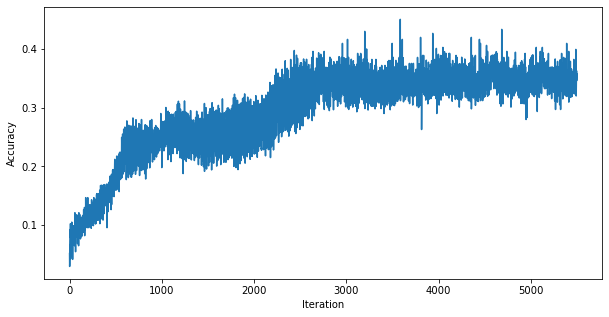

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

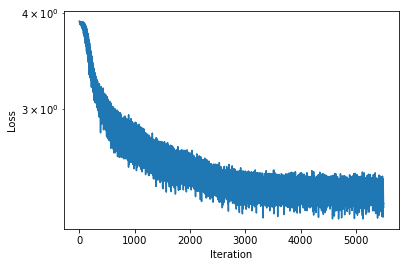

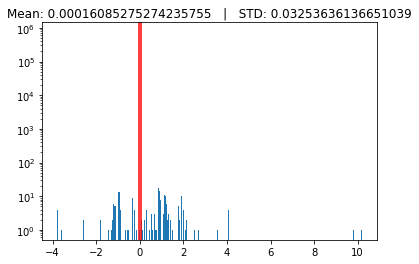

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 9.345454545454546


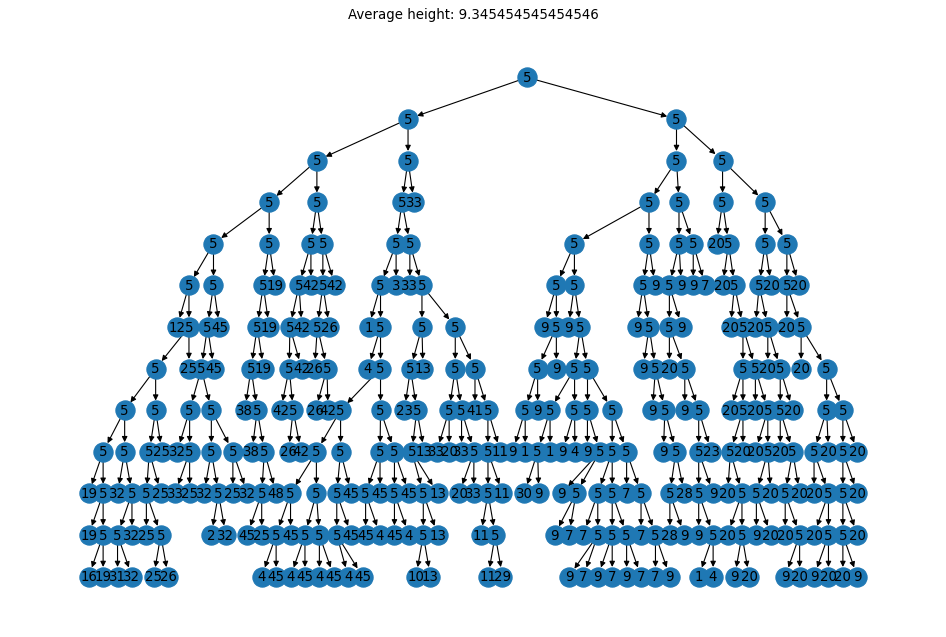

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 165


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/miniconda3/envs/rambo/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

15
============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============


/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
296
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25 ==============
252
============== Pattern 26 ==============
============== Pattern 27 ==============
============== Pattern 28 ==============
============== Pattern 29 ==============
============== Pattern 30 ==============
===========